# Data analysis

### Import of libraries

In [2]:
import pandas as pd
import json
import numpy as np
# import scipy as sp
import matplotlib.pyplot as plt
import os, re, sys, glob, math
import warnings; warnings.simplefilter('ignore')
# import statsmodels.api as sm # import statsmodels
import lzma 
import base64
from statistics import mean, median
from matplotlib.ticker import PercentFormatter
# from datetime import datetime

ModuleNotFoundError: No module named 'numpy'

### Import of data

In [3]:
subfolder = '10rounds'
outputpath = f'../output/{subfolder}/'
outputpathErrors = f'../output/{subfolder}/errors/'

### Cleaning data

In [4]:
def merge_all_files(keyword,subfolder='main'):
    all_files = glob.glob(os.path.join(r'../data/'+subfolder+'/', keyword + '*.csv'))
    return pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True, sort=True)

data = merge_all_files('10rounds',subfolder=subfolder)
sessions = ['01cf0vyv', 'i43zarvd','z3g308v4'] 
# Only keep those in-session who finished 
data = data[data['session.code'].isin(sessions) & data['participant._current_page_name'].isin(['Redirect'])]
data = data.dropna(subset=['participant.label'])
print(len(data))

NameError: name 'glob' is not defined

## CQs

In [ ]:
data['info_cost_cq_mistakes'] = data[['informational_cost.1.player.info_cost_cq_mistakes','informational_cost.2.player.info_cost_cq_mistakes','informational_cost.3.player.info_cost_cq_mistakes','informational_cost.4.player.info_cost_cq_mistakes','informational_cost.5.player.info_cost_cq_mistakes','strategy_method.1.player.info_cost_cq_mistakes','strategy_method.2.player.info_cost_cq_mistakes','strategy_method.3.player.info_cost_cq_mistakes','strategy_method.4.player.info_cost_cq_mistakes','strategy_method.5.player.info_cost_cq_mistakes']].sum(axis=1)
# print(data[['info_cost_cq_mistakes', 'strategy_method.1.player.info_cost_cq_mistakes','strategy_method.2.player.info_cost_cq_mistakes','strategy_method.3.player.info_cost_cq_mistakes', 'informational_cost.1.player.info_cost_cq_mistakes','informational_cost.2.player.info_cost_cq_mistakes','informational_cost.3.player.info_cost_cq_mistakes']])
data['intro_cq_mistakes'] = data[['informational_cost.1.player.intro_cq_mistakes', 'strategy_method.1.player.intro_cq_mistakes']].sum(axis=1)
# print(data[['intro_cq_mistakes','informational_cost.1.player.intro_cq_mistakes', 'strategy_method.1.player.intro_cq_mistakes']])

col_list = []
col_list_names = []
for col in data[['info_cost_cq_mistakes','intro_cq_mistakes']]:
    col_list.append(data[col])
    col_list_names.append(col)

for var in col_list:
    try:
        print(var.name)
        fig, ax = plt.subplots()
        y = [int(i) for i in  var]
        xLabels = range(max(y)+2)
        x = np.arange(max(y)+2)
        ax.hist(y,x-0.5, width=1)
        plt.ylabel('Frequency')
        for i in range(max(y)+1):
            plt.text(i,y.count(i)+.2,y.count(i), color='blue')
        plt.xticks(x, xLabels)
        plt.xlabel('Number of Errors')
#         plt.title(f"{var.name[19:-9]}; N={len(var)}")
        plt.tight_layout()
#         plt.savefig(outputpathErrors+ var.name[10:-9] +'.png',dpi=1000)
        plt.show()
    except:
        print('Variable missing:', var.name)

In [ ]:
data['cum_mistakes']=data[col_list_names].sum(axis=1)

maximum_mistakes_allowed = 100 
var = data[data['cum_mistakes']<maximum_mistakes_allowed]['cum_mistakes']
fig, ax = plt.subplots()
y = [int(i) for i in  var]
xLabels = range(max(y)+2)
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+1):
    plt.text(i,y.count(i)+.2,y.count(i), color='blue')
plt.xticks(x, xLabels)
plt.xlabel('Number of Errors')
plt.title(f"{var.name}; N={len(var)}")
plt.tight_layout()
# plt.savefig(outputpathErrors+ var.name +'.png',dpi=1000)
plt.show()

data = data[data['cum_mistakes']<maximum_mistakes_allowed]

### Destring param_rounds 

In [4]:
try:
    for ind in data.index:
        ini_list = data['participant.param_rounds'][ind]
        res = ini_list.strip('][').split(', ')
        data['participant.param_rounds'][ind] = res
    print(data['participant.param_rounds'])
except:
    print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')

# Create a column for each round, with that round's parameterization (which varies by participant)
for i in range(1,11):
    myList = []
    for ind in data.index:
        myList.append(int(data['participant.param_rounds'][ind][i-1]))
    #     print(myList,  data['participant.param_rounds'][ind])
    data[f'Round{i}Param'] = myList
#     print(data[f'Round{i}Param'].head(), data['participant.param_rounds'].head())

105    [1, 5, 3, 9, 2, 7, 4, 8, 6, 10]
106    [1, 9, 7, 4, 5, 10, 3, 8, 2, 6]
107    [1, 7, 8, 2, 10, 6, 9, 5, 3, 4]
108    [1, 8, 5, 6, 2, 3, 10, 4, 7, 9]
110    [1, 4, 7, 3, 2, 8, 5, 9, 10, 6]
                    ...               
255    [1, 9, 4, 3, 8, 10, 5, 6, 7, 2]
256    [1, 5, 9, 10, 4, 3, 6, 7, 8, 2]
258    [1, 7, 10, 9, 6, 5, 4, 3, 8, 2]
259    [1, 10, 4, 3, 5, 7, 8, 9, 6, 2]
260    [1, 7, 4, 9, 5, 10, 8, 3, 6, 2]
Name: participant.param_rounds, Length: 91, dtype: object


Create Columns for Computer type and Environment choice

In [5]:
try:
    for ind in data.index:
        ini_list = data['participant.compType'][ind]
        res = ini_list.strip('][').split(' ')
        data['participant.compType'][ind] = res
    print(data['participant.compType'])
except:
    print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')
    
for i in range(1,11):
    myList = []
    for ind in data.index:
        myList.append(int(data['participant.compType'][ind][i-1]))
    data[f'comp_type_R{i}'] = myList

for i in range(1,11):
    myList = []
    for ind in data.index:
        if data['participant.treatment'][ind]=='strategy':
            myList.append(int(data[f'strategy_method.{i}.player.environment_choice'][ind]))
        else:
            myList.append(int(data[f'informational_cost.{i}.player.environment_choice'][ind]))
    data[f'EnvChoice_R{i}'] = myList

105    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
106    [0, 0, 1, 1, 1, 0, 0, 0, 1, 1]
107    [0, 1, 1, 0, 0, 0, 1, 1, 0, 1]
108    [1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
110    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
                    ...              
255    [1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
256    [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
258    [0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
259    [1, 1, 1, 1, 0, 0, 1, 0, 1, 0]
260    [0, 1, 1, 1, 0, 0, 1, 0, 1, 0]
Name: participant.compType, Length: 91, dtype: object


###  Split data by treatments

In [12]:
# Slice data by treatments and parameterizations
data_base = data[data['participant.treatment']=='base']
data_salient = data[data['participant.treatment']=='salient']
data_strategy = data[data['participant.treatment']=='strategy']
print(len(data_base))
print(len(data_salient))
print(len(data_strategy))

# rounds_num = 10
# for i in range(1,rounds_num+1):
#     base_sep = data_base[data_base[f'Round{i}Param']<6] # baseline when separating is optimal
#     base_pool = data_base[data_base[f'Round{i}Param']>=6] # baseline when pooling is optimal
#     salient_sep = data_salient[data_salient[f'Round{i}Param']<6] # salient when separating is optimal
#     salient_pool = data_salient[data_salient[f'Round{i}Param']>=6] # salient when pooling is optimal

# print(len(base_sep))
# print(len(base_pool))
# print(len(salient_sep))
# print(len(salient_pool))

29
27
27


In [13]:
print(data_base['informational_cost.1.player.environment_choice'].value_counts())
print(data_salient['informational_cost.1.player.environment_choice'].value_counts())
print(data_strategy['strategy_method.1.player.environment_choice'].value_counts())
# environment_choice is 1 if chose Separate and 0 if chose Pool

1.0    21
0.0     8
Name: informational_cost.1.player.environment_choice, dtype: int64
0.0    19
1.0     8
Name: informational_cost.1.player.environment_choice, dtype: int64
0.0    19
1.0     8
Name: strategy_method.1.player.environment_choice, dtype: int64


### Check lottery preferences 

[0.8461538461538461, 0.8681318681318682, 0.8131868131868132, 0.8351648351648352, 0.8131868131868132, 0.8333333333333334]


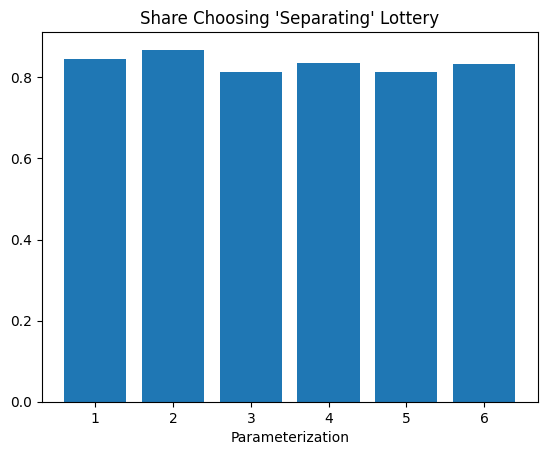

In [7]:
lottery_risky_share = []
for i in range(1,7):
    data[f'lottery.1.player.lottery{i}'] = data[f'lottery.1.player.lottery{i}'].replace(2, 0)
    lottery_risky_share += [np.mean(data[f'lottery.1.player.lottery{i}'])]
print(lottery_risky_share)

plt.bar(range(1,7), height=lottery_risky_share)
plt.title("Share Choosing 'Separating' Lottery")
plt.xlabel("Parameterization")
plt.savefig(outputpath + f'lottery_choice.png',dpi=1000)
plt.show()

#### Are there people who always choose the Pooling lottery?

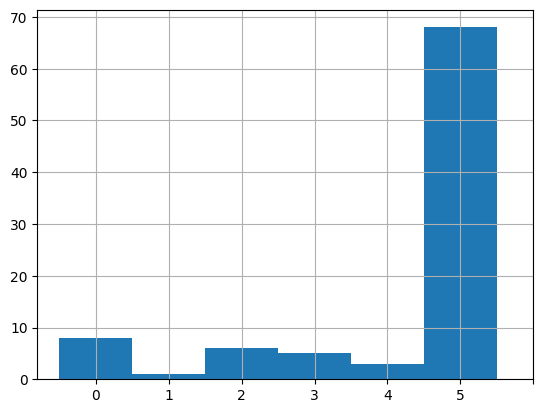

In [9]:
data['total_pool_lottery'] = data[f'lottery.1.player.lottery1']+data[f'lottery.1.player.lottery2']+data[f'lottery.1.player.lottery3']+data[f'lottery.1.player.lottery4']+data[f'lottery.1.player.lottery5']
data['total_pool_lottery'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5])
plt.xticks(np.arange(0,7), ['0', '1', '2', '3', '4', '5', ''])  # Set text labels.
plt.show()

[0.927710843373494, 0.9518072289156626, 0.891566265060241, 0.9156626506024096, 0.891566265060241, 0.9259259259259259]


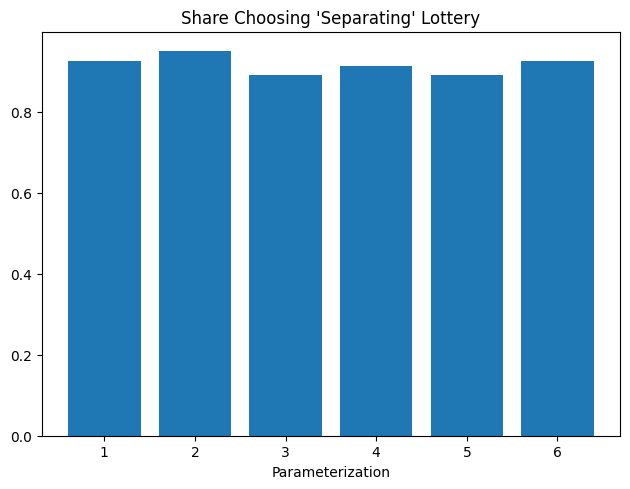

In [10]:
lottery_risky_share = []
data_temp = data[data['total_pool_lottery']>0]
for i in range(1,7):
    lottery_risky_share += [np.mean(data_temp[f'lottery.1.player.lottery{i}'])]
print(lottery_risky_share)

plt.bar(range(1,7), height=lottery_risky_share)
plt.title("Share Choosing 'Separating' Lottery")
plt.tight_layout()
plt.xlabel("Parameterization")
# plt.savefig(outputpath + f'lottery_choice.png',dpi=1000)
plt.show()

In [11]:
# data = data[data['total_pool_lottery']>0]

In [ ]:
for i in range(1,11): 
    fig, ax = plt.subplots()
    base_risk = data[data[f'Round{i}Param']<6] # plot only when pooling is a mistake
    y = [int(j) for j in base_risk[f'informational_cost.{i}.player.environment_choice']] # plot only where risk-taking optimal
    xLabels = ['Separate', 'Pool', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Base: Revelation Choice R{i} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Base_environment{i}.png',dpi=1000)
    plt.show()

In [ ]:
for i in range(2,11): 
    fig, ax = plt.subplots()
    base_risk = data[data[f'Round{i}Param']>5] # plot only when separating is a mistake
    y = [int(j) for j in base_risk[f'informational_cost.{i}.player.environment_choice']] # plot only where risk-taking optimal
    xLabels = ['Separate', 'Pool', '']
    x = np.arange(max(y)+2)
    ax.hist(y,x-0.5, width=1)
    plt.ylabel('Frequency')
    for j in range(max(y)+2):
        plt.text(j,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
    plt.xticks(x, xLabels)
    plt.title(f'Base: Revelation Choice R{i} N={len(y)}')
    plt.tight_layout()
    plt.savefig(outputpath + f'Base_environment{i}.png',dpi=1000)
    plt.show()

In [ ]:
data['participant.payoff'].hist()
mean(data['participant.payoff'])

## Revelation by decision

5 params are Separating in baseline in salient; 6 params are Separating in Strategy --- update this later!!!
[12.5, 22.22222222222222, 28.57142857142857, 22.22222222222222, 16.666666666666664, 30.000000000000004, 18.181818181818176, 50.0]
[17.647058823529413, 11.11111111111111, 22.22222222222222, 20.0, 0.0, 10.0, 11.11111111111111, 9.090909090909092, 42.857142857142854, 5.88235294117647]
[8, 9, 7, 9, 6, 10, 11, 10]
[17, 9, 9, 10, 6, 10, 9, 11, 7, 17]
Base: [72.41379310344827, 50.0, 38.46153846153847, 50.0, 23.076923076923077, 46.15384615384615, 53.84615384615385, 54.54545454545454, 36.36363636363637, 62.5] Salient: [29.629629629629626, 10.0, 16.666666666666664, 36.36363636363637, 16.666666666666664, 16.666666666666664, 15.384615384615385, 8.333333333333332, 7.6923076923076925, 30.76923076923077] Strategy: [29.629629629629626, 21.428571428571427, 23.076923076923077, 33.33333333333333, 38.46153846153847, 14.285714285714285, 28.57142857142857, 23.076923076923077, 50.0, 18.51851851851852]


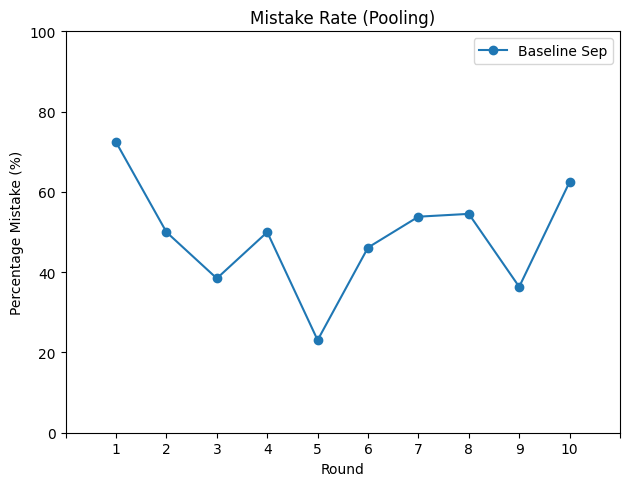

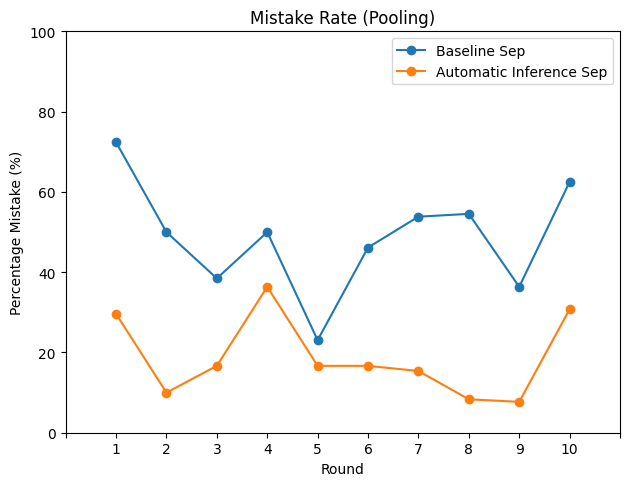

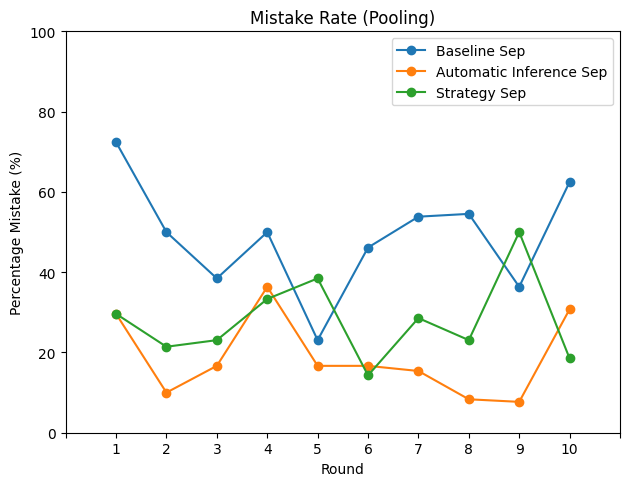

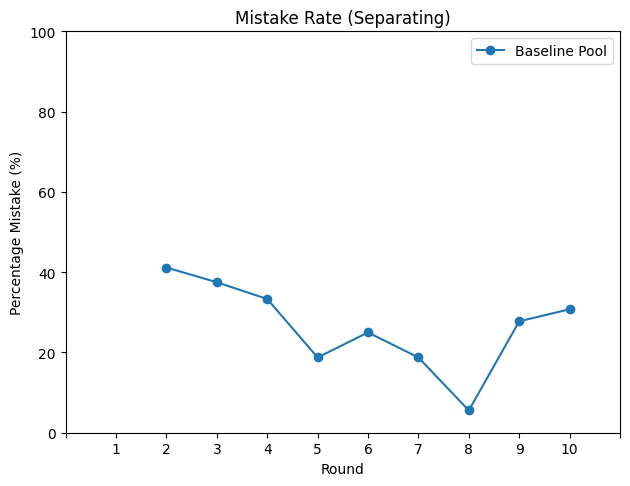

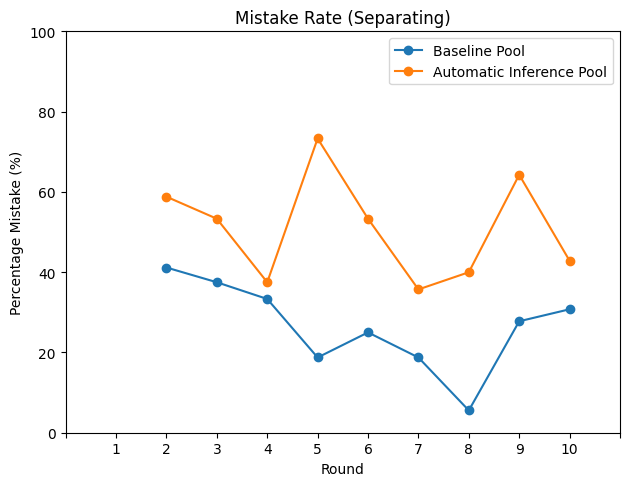

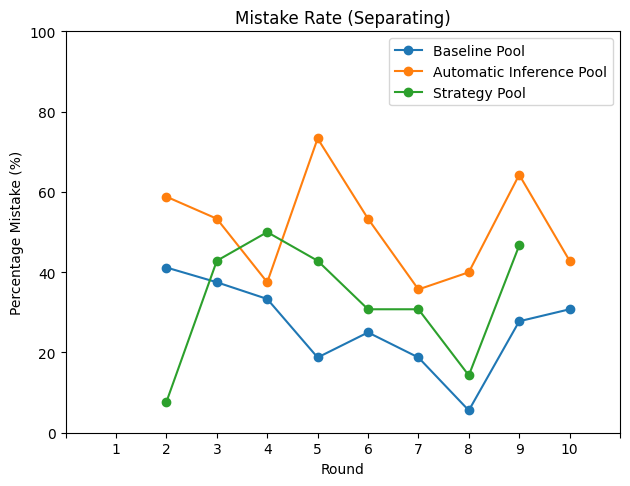

In [14]:
mist_base_sep = []
mist_base_pool = []
mist_salient_sep = []
mist_salient_pool = []
mist_strategy_sep = []
mist_strategy_pool = []
mist_strategy_sep2 = []
mist_strategy_pool2 = []
rounds_num = 10
lengths_base_sep=[]
lengths_base_pool=[]
lengths_salient_sep=[]
lengths_salient_pool=[]
lengths_strategy_sep=[]
lengths_strategy_pool=[]
lengths_strategy_sep2=[]
lengths_strategy_pool2=[]
print('5 params are Separating in baseline in salient; 6 params are Separating in Strategy --- update this later!!!')

for i in range(1,rounds_num+1):
#   BASELINE
    # base_sep = data_base[data_base[f'Round{i}Param']<6] # baseline when separating is optimal
    # base_pool = data_base[data_base[f'Round{i}Param']>=6] # baseline when pooling is optimal
    # base_risk = base[base[f'risk_taker_R{i}'] == 1] # this picks people who picked risky option in that round's lottery
    # base_risk = base_risk[base_risk[f'Round{i}Param'] != 5] # this kicks out those for whom pooling was optimal
    base_sep = data_base[data_base[f'Round{i}Param']<6] # baseline when separating is optimal
    base_pool = data_base[data_base[f'Round{i}Param']>=6] # baseline when pooling is optimal
    salient_sep = data_salient[data_salient[f'Round{i}Param']<6] # salient when separating is optimal
    salient_pool = data_salient[data_salient[f'Round{i}Param']>=6] # salient when pooling is optimal
    strategy_sep = data_strategy[data_strategy[f'Round{i}Param']<7] # strategy when separating is optimal
    strategy_pool = data_strategy[data_strategy[f'Round{i}Param']>=7] # strategy when pooling is optimal
    strategy_sep2 = data_strategy[(data_strategy[f'Round{i}Param']<7) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepGood']==1) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepBad']==3)] # strategy when separating is optimal
    strategy_pool2 = data_strategy[(data_strategy[f'Round{i}Param']>=7) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepGood']==3) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepBad']==3) & (data_strategy[f'strategy_method.{i}.player.bonusChoicePool']==3)] # strategy when pooling is optimal
    mist_environment = base_sep[f'informational_cost.{i}.player.environment_choice'].mean()*100
    mist_base_sep.append(mist_environment)
    lengths_base_sep.append(len(base_sep[base_sep[f'Round{i}Param']<6]))
    mist_environment = salient_sep[f'informational_cost.{i}.player.environment_choice'].mean()*100
    mist_salient_sep.append(mist_environment)
    lengths_salient_sep.append(len(salient_sep[salient_sep[f'Round{i}Param']<6]))
    mist_environment = strategy_sep[f'strategy_method.{i}.player.environment_choice'].mean()*100
    mist_strategy_sep.append(mist_environment)
    lengths_strategy_sep.append(len(strategy_sep[strategy_sep[f'Round{i}Param']<7]))
    mist_environment = strategy_sep2[f'strategy_method.{i}.player.environment_choice'].mean()*100
    mist_strategy_sep2.append(mist_environment)
    lengths_strategy_sep2.append(len(strategy_sep2[strategy_sep2[f'Round{i}Param']<7]))
    if i>1:
        mist_environment = (1-base_pool[f'informational_cost.{i}.player.environment_choice'].mean())*100
        mist_base_pool.append(mist_environment)
        lengths_base_pool.append(len(base_pool[base_pool[f'Round{i}Param']>=6]))
        mist_environment = (1-salient_pool[f'informational_cost.{i}.player.environment_choice'].mean())*100
        mist_salient_pool.append(mist_environment)
        lengths_salient_pool.append(len(salient_pool[salient_pool[f'Round{i}Param']>=6]))
        if i<rounds_num:
            mist_environment = (1-strategy_pool[f'strategy_method.{i}.player.environment_choice'].mean())*100
            mist_strategy_pool.append(mist_environment)
            lengths_strategy_pool.append(len(strategy_pool[strategy_pool[f'Round{i}Param']>=7]))
            mist_environment = (1-strategy_pool2[f'strategy_method.{i}.player.environment_choice'].mean())*100
            mist_strategy_pool2.append(mist_environment)
            lengths_strategy_pool2.append(len(strategy_pool2[strategy_pool2[f'Round{i}Param']>=7]))

print(mist_strategy_pool2)
print(mist_strategy_sep2)
print(lengths_strategy_pool2)
print(lengths_strategy_sep2)

# print('Chose risky in first round:', strategy[strategy['risk_taker_R1'] == 1]['risk_taker_R1'].count())
print('Base:', mist_base_sep, 'Salient:', mist_salient_sep, 'Strategy:', mist_strategy_sep)

for fig in range(6): 
    # plt.plot(range(1,rounds_num+1), mist_base_sep, label=f'Baseline Sep N={lengths_base_sep}', marker="o")
    if fig<=2:
        plt.plot(range(1,rounds_num+1), mist_base_sep, label=f'Baseline Sep', marker="o")    # plt.plot(range(1,2), avgs_base, label=f'Baseline N={lengths_base[0]}', marker="o")
    if fig>0 and fig<=2:
        # plt.plot(range(1,rounds_num+1), mist_salient_sep, label=f'Salient Sep N={lengths_salient_sep}', marker="o")
        plt.plot(range(1,rounds_num+1), mist_salient_sep,  label=f'Automatic Inference Sep', marker="o")

    if fig>1 and fig<=2:
        # plt.plot(range(1,rounds_num+1), mist_salient_sep, label=f'Salient Sep N={lengths_salient_sep}', marker="o")
        plt.plot(range(1,rounds_num+1), mist_strategy_sep,  label=f'Strategy Sep', marker="o")

    # # plt.plot(range(1,2), avgs_salient, label=f'Salient N={lengths_salient[0]}', marker="o")
    if fig>2:
        # plt.plot(range(2,rounds_num+1), mist_base_pool, label=f'Baseline Pool N={lengths_base_pool}', marker="o")
        plt.plot(range(2,rounds_num+1), mist_base_pool, label=f'Baseline Pool', marker="o")

    if fig>3:
        # plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Salient Pool N={lengths_salient_pool}', marker="o")
        plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Automatic Inference Pool', marker="o")

    if fig>4:
        # plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Salient Pool N={lengths_salient_pool}', marker="o")
        plt.plot(range(2,rounds_num), mist_strategy_pool, label=f'Strategy Pool', marker="o")

    # # plt.plot(range(1,rounds_num+1), avgs_strategy, label=f'Strategy Method N={lengths_strategy}', marker="o")
    # plt.plot(range(1,2), avgs_strategy, label=f'Strategy Method N={lengths_strategy[0]}', marker="o")

    plt.xlabel("Round")
    plt.ylabel("Percentage Mistake (%)")
    plt.xlim(0, rounds_num+1)
    plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    # plt.axhline(y=avgs_base_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
    # plt.text(2.5,avgs_base_avg+3,str(round(avgs_base_avg,1))+'%')
    # plt.text(0.85,avgs_base[0]+3,str(round(avgs_base[0]))+'%')
    # plt.text(0.85,avgs_salient[0]+3,str(round(avgs_salient[0]))+'%')
    # plt.text(0.85,avgs_strategy[0]-4,str(round(avgs_strategy[0]))+'%')

    # plt.axhline(y=avgs_sal_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
    # plt.text(2.5,avgs_sal_avg-4,str(round(avgs_sal_avg,1))+'%')

    plt.legend()
    plt.tight_layout()
    # plt.savefig(outputpath + 'environment_by_round_baseline_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_baseline.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_salient_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_salient.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_strategy_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_strategy.png',dpi=1000)
    if fig==0:
        plt.title(f'Mistake Rate (Pooling)')
        plt.savefig(outputpath + 'environment_by_round_baseline_sep.png',dpi=1000)
    if fig==1:
        plt.title(f'Mistake Rate (Pooling)')
        plt.savefig(outputpath + 'environment_by_round_baseline_salient_sep.png',dpi=1000)
    if fig==2:
        plt.title(f'Mistake Rate (Pooling)')
        plt.savefig(outputpath + 'environment_by_round_baseline_salient_strategy_sep.png',dpi=1000)
    if fig==3:
        plt.title(f'Mistake Rate (Separating)')
        plt.savefig(outputpath + 'environment_by_round_baseline_pool.png',dpi=1000)
    if fig==4:
        plt.title(f'Mistake Rate (Separating)')
        plt.savefig(outputpath + 'environment_by_round_baseline_salient_pool.png',dpi=1000)
    if fig==5:
        plt.title(f'Mistake Rate (Separating)')
        plt.savefig(outputpath + 'environment_by_round_baseline_salient_strategy_pool.png',dpi=1000)
    plt.show()




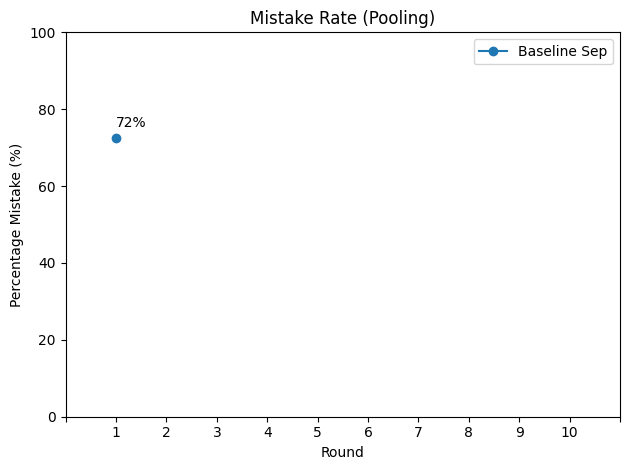

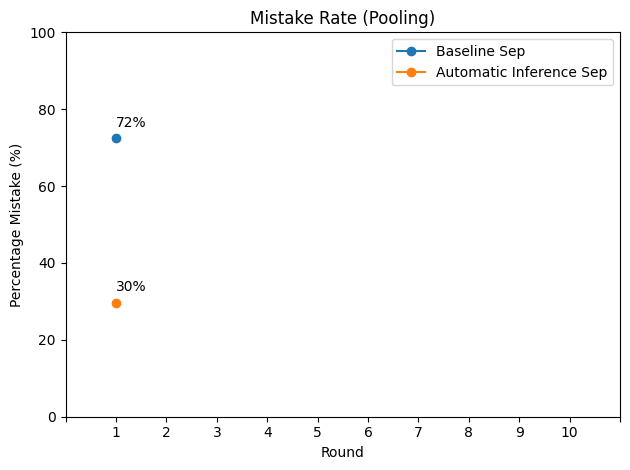

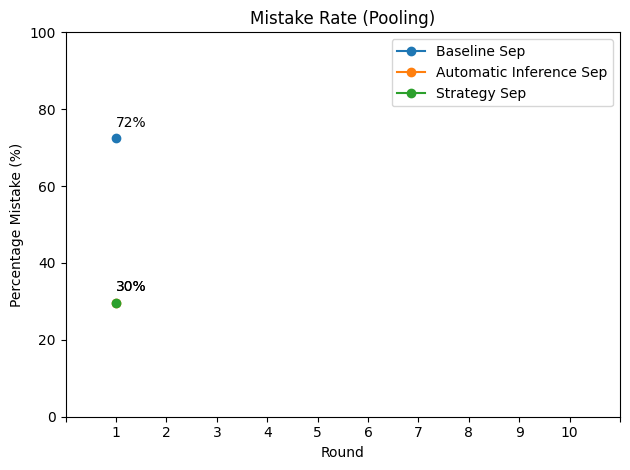

In [15]:
plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate (Pooling)')
plt.tight_layout()
plt.savefig(outputpath + 'environment_round_1_baseline_sep.png',dpi=1000)
plt.show()

plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.plot([1], mist_salient_sep[0], label=f'Automatic Inference Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.text(1,mist_salient_sep[0]+3,str(round(mist_salient_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate (Pooling)')
plt.tight_layout()
plt.savefig(outputpath + 'environment_round_1_salient_sep.png',dpi=1000)
plt.show()

plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.plot([1], mist_salient_sep[0], label=f'Automatic Inference Sep', marker="o")
plt.plot([1], mist_strategy_sep[0], label=f'Strategy Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.text(1,mist_salient_sep[0]+3,str(round(mist_salient_sep[0]))+'%')
plt.text(1,mist_strategy_sep[0]+3,str(round(mist_strategy_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate (Pooling)')
plt.tight_layout()
plt.savefig(outputpath + 'environment_round_1_strategy_sep.png',dpi=1000)
plt.show()

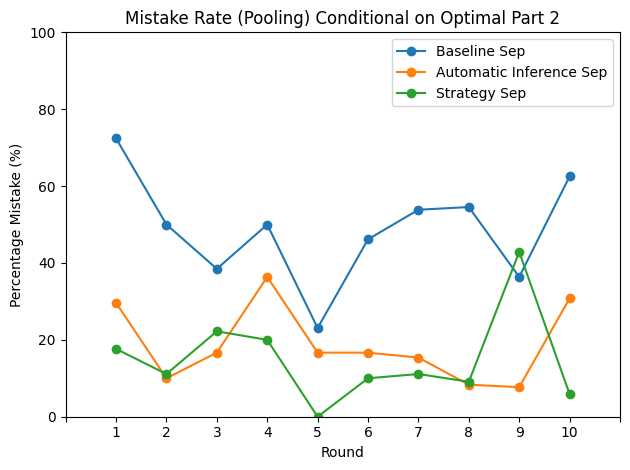

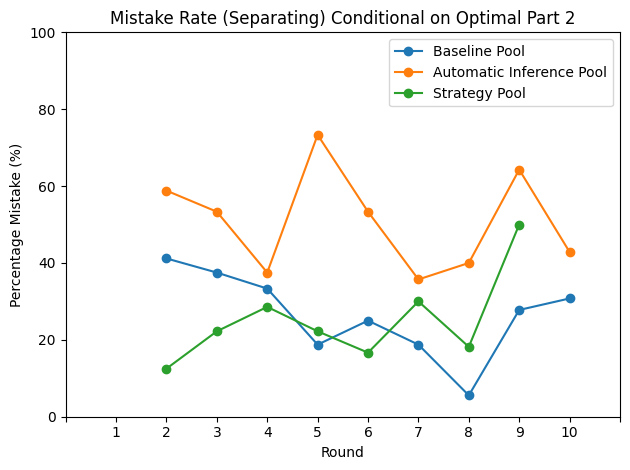

In [16]:

plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.title(f'Mistake Rate (Pooling) Conditional on Optimal Part 2')
plt.tight_layout()
plt.plot(range(1,rounds_num+1), mist_base_sep, label=f'Baseline Sep', marker="o")
plt.plot(range(1,rounds_num+1), mist_salient_sep, label=f'Automatic Inference Sep', marker="o")
# plt.plot(range(2,rounds_num), mist_strategy_pool2, label=f'Strategy Pool', marker="o")
plt.plot(range(1,rounds_num+1), mist_strategy_sep2, label=f'Strategy Sep', marker="o")
plt.legend()
plt.savefig(outputpath + 'environment_by_round_strategy_opt_part2_sep.png',dpi=1000)
plt.show()

plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.title(f'Mistake Rate (Separating) Conditional on Optimal Part 2')
plt.tight_layout()
plt.plot(range(2,rounds_num+1), mist_base_pool, label=f'Baseline Pool', marker="o")
plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Automatic Inference Pool', marker="o")
plt.plot(range(2,rounds_num), mist_strategy_pool2, label=f'Strategy Pool', marker="o")
# plt.plot(range(1,rounds_num+1), mist_strategy_sep2, label=f'Strategy Sep', marker="o")
plt.legend()
plt.savefig(outputpath + 'environment_by_round_strategy_opt_part2_pool.png',dpi=1000)
plt.show()

### Let's look at those who see parameterization 5, do they make mistakes?

In [ ]:
# for i in range(1,rounds_num+1):
#     print(base[base[f'Round{i}Param'] == 5][[f'risk_taker_R{i}', f'informational_cost.{i}.player.environment_choice']])
# #     print(base[[f'Round{i}Param', f'risk_taker_R{i}']])

### How much do people pool when its optimal to pool? - in Base

In [ ]:
# avgs_base = []
# for i in range(1,6):
# #     BASELINE
#     base_risk = base[base[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
#     base_risk = base_risk[(base_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
#     avg_environment = base_risk[f'informational_cost.{i}.player.environment_choice'].mean()
#     avgs_base.append(avg_environment)
#     print(len(base_risk))
# print(avgs_base)
# print(sum(avgs_base)/len(avgs_base))

# avgs_salient = []
# for i in range(1,6):
# #     SALIENT
#     salient_risk = salient[salient[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
#     salient_risk = salient_risk[(salient_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
#     avg_environment = salient_risk[f'informational_cost.{i}.player.environment_choice'].mean()
#     avgs_salient.append(avg_environment)
#     print(len(salient_risk))
# print(avgs_salient)
# print(sum(avgs_salient)/len(avgs_salient))

# avgs_strategy = []
# for i in range(1,6):
# #     SALIENT
#     strategy_risk = strategy[strategy[f'risk_taker_R{i}'] == 0] # this picks people who picked safe option in that round's lottery (for whom pooling here is optimal)
#     strategy_risk = strategy_risk[(strategy_risk[f'Round{i}Param'] == 5)] # this picks those for whom pooling was optimal
#     avg_environment = strategy_risk[f'strategy_method.{i}.player.environment_choice'].mean()
#     avgs_strategy.append(avg_environment)
#     print(len(strategy_risk))
# print(avgs_strategy)
# print(sum(avgs_strategy)/len(avgs_strategy))

### Do people who (always) separate when its optimal to separate, also pool when its optimal to pool? - in Base

In [ ]:
# for i in range(1,6):
#     base[f'optimal{i}'] = np.nan
#     for ind in base.index:
#         base[f'optimal{i}'][ind] = 1 if (base[f'risk_taker_R{i}'][ind]==1 and base[f'informational_cost.{i}.player.environment_choice'][ind]==0) else 0
#         base[f'optimal{i}'][ind] = 1 if (base[f'risk_taker_R{i}'][ind]==0 and base[f'informational_cost.{i}.player.environment_choice'][ind]==1) else base[f'optimal{i}'][ind]
#     print(base[[f'optimal{i}',f'risk_taker_R{i}',f'informational_cost.{i}.player.environment_choice']])
# #         if base[f'optimal{i}'][ind]:
# #             base[f'optimal{i}'] = 0  


In [ ]:
# #  pooling_round1 and pooling_round2 pick the rounds in which pooling is optimal for each subject
# base['pooling_round1'] = np.nan
# for i in range(1,6):
#     for ind in base.index:
#         if base[f'Round{i}Param'][ind] == 5:
#             base['pooling_round1'][ind] = i

# base['always_optimally_separated'] = np.nan
# for ind in base.index:
#     counter = 0
#     a = base['pooling_round1'][ind]
#     rounds = [1,2,3,4,5]
#     rounds.remove(a)
#     for i in rounds:
#         if base[f'optimal{i}'][ind]==1 and base[f'risk_taker_R{i}'][ind]==1:
#             counter +=1
#     base['always_optimally_separated'][ind]=1 if counter == 4 else 0

# base_optimally_separated = base[base['always_optimally_separated'] == 1] # this picks people who chose optimally 
# pooling_base = []
# for ind in base_optimally_separated.index:
#     a = int(base_optimally_separated['pooling_round1'][ind])
#     choice_in_pooling = base_optimally_separated[f'informational_cost.{a}.player.environment_choice'][ind]
#     pooling_base.append(choice_in_pooling)
# print(len(base_optimally_separated),len(pooling_base),pooling_base)
# print('Fraction of the 20 decisions in which they pool when its optimal, for people who always do optimal:', sum(pooling_base)/len(pooling_base))

In [ ]:
# avgs_base = []
# for i in range(1,6):
# #     BASELINE
#     avg_environment = base[f'optimal{i}'].mean()*100
#     avgs_base.append(avg_environment)

# plt.plot(range(1,6), avgs_base, label='Baseline - Optimal', marker="o")

# plt.xlabel("Round")
# plt.ylabel("Percentage Optimal (%)")
# plt.xlim(1, 5)
# plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
# plt.ylim(0, 100)
# plt.axvline(x=5.5, linewidth=2, color = 'k')
# plt.legend()
# plt.title('Optimal Revelation By Round')
# plt.tight_layout()
# # plt.savefig(outputpath + 'environment_by_round.png',dpi=1000)
# plt.show()

## Let's look at parameterization to check whether we learn anything from that

In [ ]:
# for i in range(1,6):    
#     fig, ax = plt.subplots()
#     data_risk = salient[salient[f'risk_taker_R{i}'] == 1] # plot only for the subsample of risk-takers
# #     data_risk = data
#     y = [int(i) for i in data_risk[f'Round{i}Param']] # plot only where risk-taking optimal
# #     print(y)
#     xLabels = ['', 'Params 1', 'Params 2', 'Params 3', 'Params 4', 'Params 5', '']
#     x = np.arange(7)
#     ax.hist(y,x-0.5, width=1)
#     plt.ylabel('Frequency')
#     for j in range(max(y)+2):
#         plt.text(j-0.35,y.count(j)-1,str(y.count(j))+ ' (' + str(round(y.count(j)*100/len(y))) +'%)', color='white')
#     plt.xticks(x, xLabels)
#     plt.title(f'Parameterization in Round {i} N={len(y)}')
#     plt.tight_layout()
# #     plt.savefig(outputpath + f'Strategy_environment{i}.png',dpi=1000)
#     plt.show()

## Bonus Choice

#### Destring compTypes, chosen_decisions, and environment_choice

In [11]:
try:
    for ind in data.index:
        ini_list = data['participant.compType'][ind]
        res = ini_list.strip('][').split(' ')
        data['participant.compType'][ind] = res
    print(data['participant.compType'])
except:
    print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')
# try:
#     for ind in data.index:
#         ini_list = data['participant.chosen_decisions'][ind]
#         res = ini_list.strip(')(').split(', ')
#         data['participant.chosen_decisions'][ind] = res
#     print(data['participant.chosen_decisions'])
# except:
#     print('you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code')

you cannot run this code twice, and you have already run it. Run "cleaning data" again to be able to run this code


##### Create 5 columns, each with compType for each round

In [38]:
for i in range(1,6):
    myList = []
    for ind in data.index:
        myList.append(int(data[f'participant.compType'][ind][i-1]))
    data[f'comp_type_R{i}'] = myList
# base = data[data['participant.treatment']== 'base']
# salient = data[data['participant.treatment']== 'salient']
# strategy = data[data['participant.treatment']== 'strategy']

### Part 2: Bonus Choice - Do people know what to do with the information?


#### Baseline

In [39]:
for i in range(1,11):
    myList = []
    for ind in data_base.index:
        myList.append(int(data_base[f'informational_cost.{i}.player.environment_choice'][ind]))
    data_base[f'EnvChoice_R{i}'] = myList
    myList = []
    for ind in data_salient.index:
        myList.append(int(data_salient[f'informational_cost.{i}.player.environment_choice'][ind]))
    data_salient[f'EnvChoice_R{i}'] = myList

In [ ]:
# avgs_pool = []
# for i in range(1,6):
#     base_pool = data_base[(data_base[f'EnvChoice_R{i}']==1) & (data_base[f'Round{i}Param']<6)] #  baseline when separating is optimal
#     bonus_choice = base_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
#     avg_pooling = bonus_choice.mean()*100
#     avgs_pool.append(avg_pooling)
# #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
#     print('N=', len(bonus_choice))
# print(avgs_pool)
# plt.plot(range(1,6), avgs_pool, label='Baseline - Hiring choice for those who pool', marker="o")

# plt.xlabel("Round")
# plt.ylabel("Percentage Hiring (%)")
# plt.xlim(1, 5)
# plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
# plt.ylim(0, 100)
# plt.axvline(x=5.5, linewidth=2, color = 'k')
# # plt.legend()
# plt.title('Baseline: Hiring if Pooled, By Round; N=()')
# plt.tight_layout()
# # plt.savefig(outputpath + 'environment_by_round.png',dpi=1000)
# plt.show()

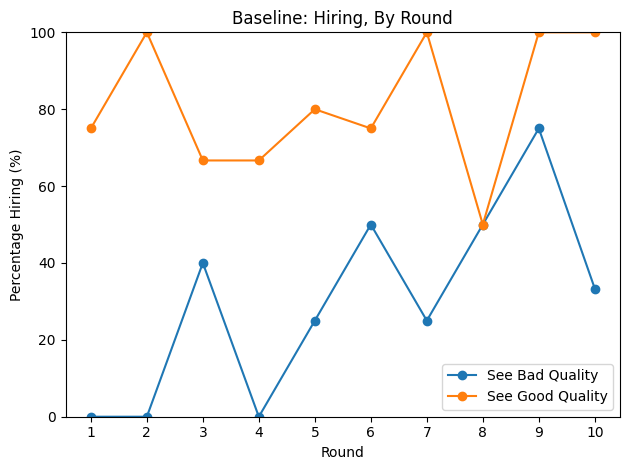

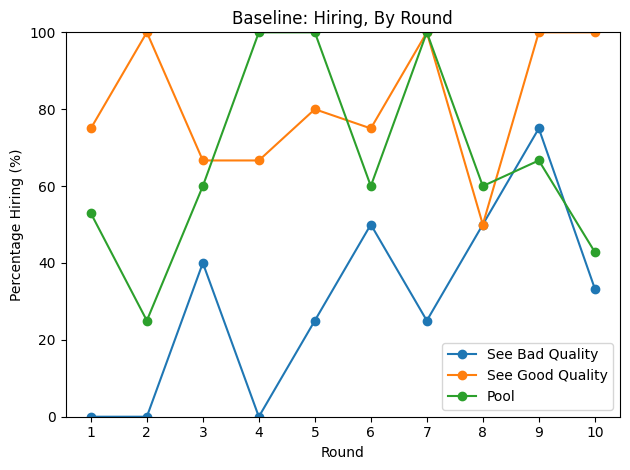

In [34]:
for fig in range(2):
    #  SEPARATE BAD
    avgs_sep = []
    lengths = []
    for i in range(1,rounds_num+1):
        base_sep = data_base[(data_base[f'EnvChoice_R{i}']==0) & (data_base[f'Round{i}Param']<6)] #  baseline when separating is optimal
        bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        # print('N=', len(bonus_choice))
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Bad Quality N=({lengths})', marker="o")
    plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Bad Quality', marker="o")


    #  SEPARATE GOOD
    avgs_sep = []
    lengths = []
    for i in range(1,rounds_num+1):
        base_sep = data_base[(data_base[f'EnvChoice_R{i}']==0) & (data_base[f'Round{i}Param']<6)] #  baseline when separating is optimal
        bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        # print('N=', len(bonus_choice))
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Good Quality N=({lengths})', marker="o")
    plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Good Quality', marker="o")


    if fig>0:
    #  POOL
        lengths = []
        avgs_pool = []
        for i in range(1,rounds_num+1):
            base_pool = data_base[(data_base[f'EnvChoice_R{i}']==1) & (data_base[f'Round{i}Param']<6)] #  baseline when separating is optimal
            bonus_choice = base_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
            # print('N=', len(bonus_choice))
            lengths.append(len(bonus_choice))
        # print(avgs_pool)
        # plt.plot(range(1,rounds_num+1), avgs_pool, label=f'Pool N=({lengths})', marker="o")
        plt.plot(range(1,rounds_num+1), avgs_pool, label=f'Pool', marker="o")


    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    # plt.xlim(1, 5)
    plt.xticks(np.arange(1,rounds_num+1), range(1,rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    plt.legend()
    plt.title(f'Baseline: Hiring, By Round')
    plt.tight_layout()
    # plt.savefig(outputpath + 'baseline_bonus_choice_by_round.png',dpi=1000)
    if fig==0:
        plt.savefig(outputpath + 'baseline_bonus_choice_by_round.png',dpi=1000)
    plt.show()

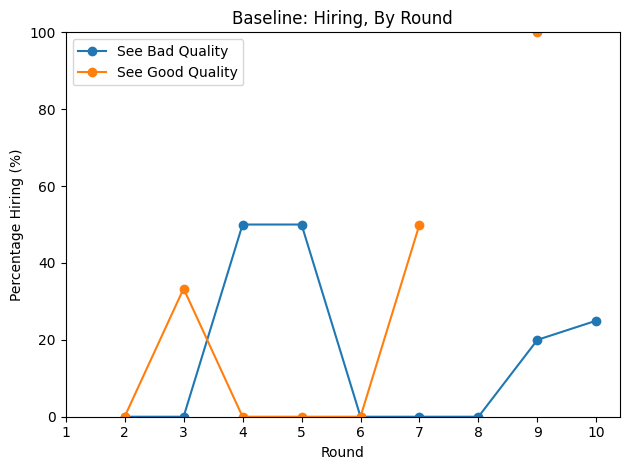

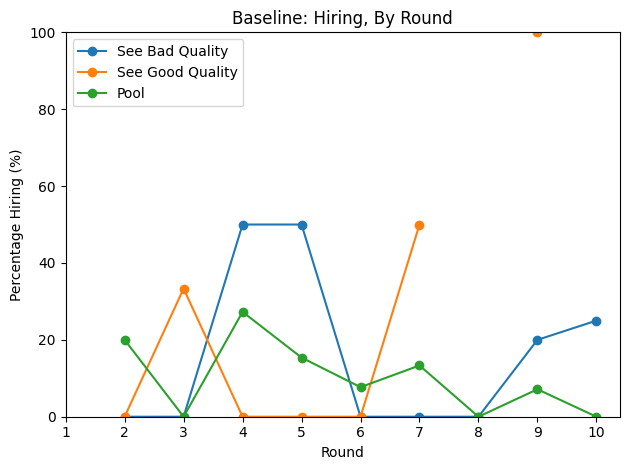

In [33]:
# Here it's optimal to not hire
for fig in range(2):
    #  SEPARATE BAD
    avgs_sep = []
    lengths = []
    for i in range(1,rounds_num+1):
        base_sep = data_base[(data_base[f'EnvChoice_R{i}']==0) & (data_base[f'Round{i}Param']>=6)] #  baseline when pooling is optimal
        bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        # print('N=', len(bonus_choice))
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Bad Quality N=({lengths})', marker="o")
    plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Bad Quality', marker="o")


    #  SEPARATE GOOD
    avgs_sep = []
    lengths = []
    for i in range(1,rounds_num+1):
        base_sep = data_base[(data_base[f'EnvChoice_R{i}']==0) & (data_base[f'Round{i}Param']>=6)] #  baseline when pooling is optimal
        bonus_choice = base_sep[base_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        # print('N=', len(bonus_choice))
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Good Quality N=({lengths})', marker="o")
    plt.plot(range(1,rounds_num+1), avgs_sep, label=f'See Good Quality', marker="o")


    if fig>0:
    #  POOL
        lengths = []
        avgs_pool = []
        for i in range(1,rounds_num+1):
            base_pool = data_base[(data_base[f'EnvChoice_R{i}']==1) & (data_base[f'Round{i}Param']>=6)] #  baseline when pooling is optimal
            bonus_choice = base_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
            # print('N=', len(bonus_choice))
            lengths.append(len(bonus_choice))
        # print(avgs_pool)
        # plt.plot(range(1,rounds_num+1), avgs_pool, label=f'Pool N=({lengths})', marker="o")
        plt.plot(range(1,rounds_num+1), avgs_pool, label=f'Pool', marker="o")


    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    # plt.xlim(1, 5)
    plt.xticks(np.arange(1,rounds_num+1), range(1,rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    plt.legend()
    plt.title(f'Baseline: Hiring, By Round')
    plt.tight_layout()
    # plt.savefig(outputpath + 'baseline_bonus_choice_by_round.png',dpi=1000)
    # if fig==0:
    #     plt.savefig(outputpath + 'baseline_bonus_choice_by_round.png',dpi=1000)
    plt.show()

### Salient

In [ ]:
# for i in range(1,6):
#     myList = []
#     for ind in salient.index:
#         myList.append(int(salient[f'informational_cost.{i}.player.environment_choice'][ind]))
#     salient[f'EnvChoice_R{i}'] = myList

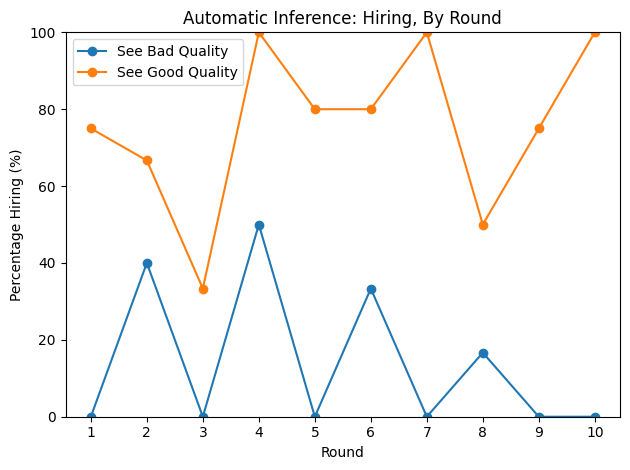

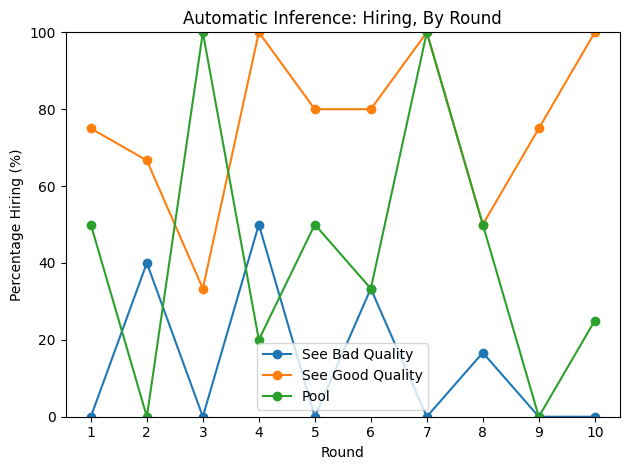

In [33]:
for fig in range(2):
    #  SEPARATE BAD
    lengths = []
    avgs_sep = []
    for i in range(1, rounds_num+1):
        salient_sep = data_salient[(data_salient[f'EnvChoice_R{i}']==0) & (data_salient[f'Round{i}Param']<6)]
        bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Bad Quality N={lengths}', marker="o")
    plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Bad Quality', marker="o")


    #  SEPARATE GOOD
    lengths = []
    avgs_sep = []
    for i in range(1, rounds_num+1):
        salient_sep = data_salient[(data_salient[f'EnvChoice_R{i}']==0) & (data_salient[f'Round{i}Param']<6)]
        bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Good Quality N={lengths}', marker="o")
    plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Good Quality', marker="o")


    if fig>0:
        #  POOL
        avgs_pool = []
        lengths = []
        for i in range(1, rounds_num+1):
            salient_pool = data_salient[(data_salient[f'EnvChoice_R{i}']==1) & (data_salient[f'Round{i}Param']<6)]
            bonus_choice = salient_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
            lengths.append(len(bonus_choice))
        # print(avgs_pool)
        # plt.plot(range(1, rounds_num+1), avgs_pool, label=f'Pool N={lengths}', marker="o")
        plt.plot(range(1, rounds_num+1), avgs_pool, label=f'Pool', marker="o")


    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    # plt.xlim(1, 5)
    plt.xticks(np.arange(1,rounds_num+1), range(1, rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    plt.legend()
    plt.title(f'Automatic Inference: Hiring, By Round')
    plt.tight_layout()
    # plt.savefig(outputpath + 'salient_bonus_choice_by_round.png',dpi=1000)
    if fig==0:
        plt.savefig(outputpath + 'salient_bonus_choice_by_round.png',dpi=1000)
    plt.show()

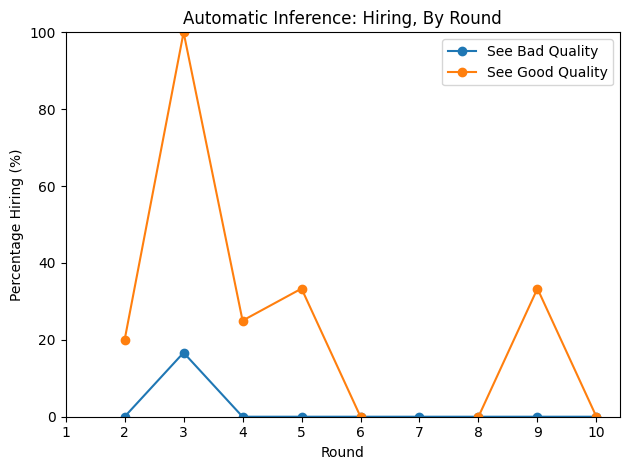

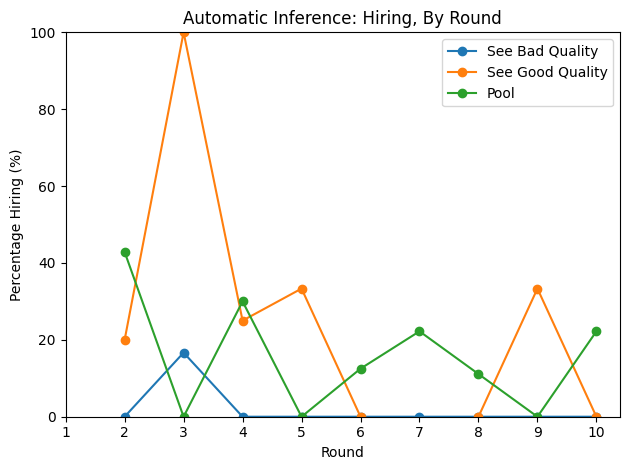

In [32]:
# Here it's optimal to not hire
for fig in range(2):
    #  SEPARATE BAD
    lengths = []
    avgs_sep = []
    for i in range(1, rounds_num+1):
        salient_sep = data_salient[(data_salient[f'EnvChoice_R{i}']==0) & (data_salient[f'Round{i}Param']>=6)] #Pooling optimal
        bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==0][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Bad Quality N={lengths}', marker="o")
    plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Bad Quality', marker="o")


    #  SEPARATE GOOD
    lengths = []
    avgs_sep = []
    for i in range(1, rounds_num+1):
        salient_sep = data_salient[(data_salient[f'EnvChoice_R{i}']==0) & (data_salient[f'Round{i}Param']>=6)] #Pooling optimal
        bonus_choice = salient_sep[salient_sep[f'comp_type_R{i}']==1][f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
        lengths.append(len(bonus_choice))
    # print(avgs_sep)
    # plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Good Quality N={lengths}', marker="o")
    plt.plot(range(1, rounds_num+1), avgs_sep, label=f'See Good Quality', marker="o")


    if fig>0:
        #  POOL
        avgs_pool = []
        lengths = []
        for i in range(1, rounds_num+1):
            salient_pool = data_salient[(data_salient[f'EnvChoice_R{i}']==1) & (data_salient[f'Round{i}Param']>=6)] #Pooling optimal
            bonus_choice = salient_pool[f'informational_cost.{i}.player.bonusChoice'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
            lengths.append(len(bonus_choice))
        # print(avgs_pool)
        # plt.plot(range(1, rounds_num+1), avgs_pool, label=f'Pool N={lengths}', marker="o")
        plt.plot(range(1, rounds_num+1), avgs_pool, label=f'Pool', marker="o")


    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    # plt.xlim(1, 5)
    plt.xticks(np.arange(1,rounds_num+1), range(1, rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    plt.legend()
    plt.title(f'Automatic Inference: Hiring, By Round')
    plt.tight_layout()
    # plt.savefig(outputpath + 'salient_bonus_choice_by_round.png',dpi=1000)
    # if fig==0:
    #     plt.savefig(outputpath + 'salient_bonus_choice_by_round.png',dpi=1000)
    plt.show()

### Strategy Method

[22.22222222222222, 14.285714285714285, 30.76923076923077, 15.384615384615385, 26.666666666666668, 6.666666666666667, 6.666666666666667, 9.090909090909092, 25.0, 25.925925925925924]
[77.77777777777779, 57.14285714285714, 76.92307692307693, 76.92307692307693, 73.33333333333333, 66.66666666666666, 53.333333333333336, 81.81818181818183, 75.0, 70.37037037037037]


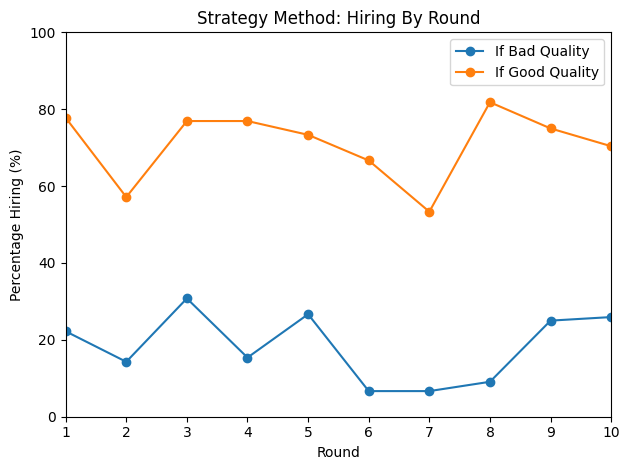

[22.22222222222222, 14.285714285714285, 30.76923076923077, 15.384615384615385, 26.666666666666668, 6.666666666666667, 6.666666666666667, 9.090909090909092, 25.0, 25.925925925925924]
[77.77777777777779, 57.14285714285714, 76.92307692307693, 76.92307692307693, 73.33333333333333, 66.66666666666666, 53.333333333333336, 81.81818181818183, 75.0, 70.37037037037037]
[44.44444444444444, 35.714285714285715, 53.84615384615385, 38.46153846153847, 53.333333333333336, 33.33333333333333, 40.0, 36.36363636363637, 33.33333333333333, 33.33333333333333]


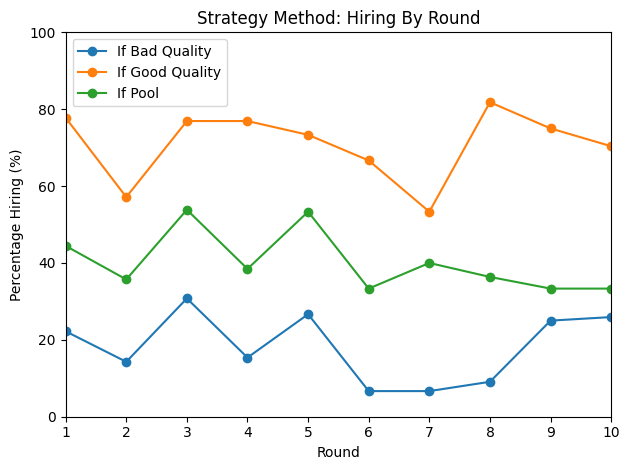

In [35]:
for fig in range(2):
    #  SEPARATE BAD
    avgs_sep = []
    for i in range(1, rounds_num+1):
        bonus_choice = data_strategy[data_strategy[f'Round{i}Param']<7][f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
    # lengths = len(bonus_choice)
    print(avgs_sep)
    plt.plot(range(1, rounds_num+1), avgs_sep, label='If Bad Quality', marker="o")

    #  SEPARATE GOOD
    avgs_sep = []
    for i in range(1, rounds_num+1):
        bonus_choice = data_strategy[data_strategy[f'Round{i}Param']<7][f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
    # lengths = len(bonus_choice)
    print(avgs_sep)
    plt.plot(range(1, rounds_num+1), avgs_sep, label='If Good Quality', marker="o")

    if fig>0:
        #  POOL
        avgs_pool = []
        for i in range(1, rounds_num+1):
            bonus_choice = data_strategy[data_strategy[f'Round{i}Param']<7][f'strategy_method.{i}.player.bonusChoicePool'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
        # lengths = len(bonus_choice)
        print(avgs_pool)
        plt.plot(range(1, rounds_num+1), avgs_pool, label='If Pool', marker="o")

    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    plt.xlim(1,  rounds_num)
    plt.xticks(np.arange(1, rounds_num+1), range(1, rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    plt.legend()
    # plt.title(f'Strategy Method: Hiring By Round N={lengths}')
    plt.title(f'Strategy Method: Hiring By Round')
    plt.tight_layout()
    if fig == 0:
        plt.savefig(outputpath + 'strategy_bonus_choice_by_round.png',dpi=1000)
    plt.show()

[nan, 7.142857142857142, 6.666666666666667, 26.666666666666668, 13.333333333333334, 35.714285714285715, 21.428571428571427, 25.0, 11.76470588235294, nan]
[nan, 35.714285714285715, 33.33333333333333, 20.0, 40.0, 42.857142857142854, 21.428571428571427, 18.75, 29.411764705882355, nan]


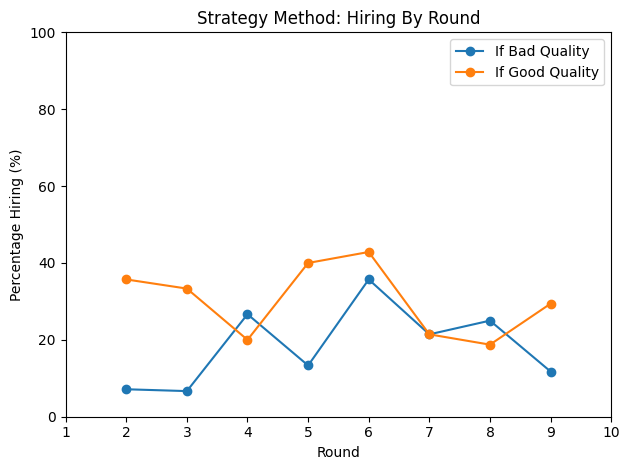

[nan, 7.142857142857142, 6.666666666666667, 26.666666666666668, 13.333333333333334, 35.714285714285715, 21.428571428571427, 25.0, 11.76470588235294, nan]
[nan, 35.714285714285715, 33.33333333333333, 20.0, 40.0, 42.857142857142854, 21.428571428571427, 18.75, 29.411764705882355, nan]
[nan, 21.428571428571427, 20.0, 26.666666666666668, 26.666666666666668, 28.57142857142857, 21.428571428571427, 25.0, 11.76470588235294, nan]


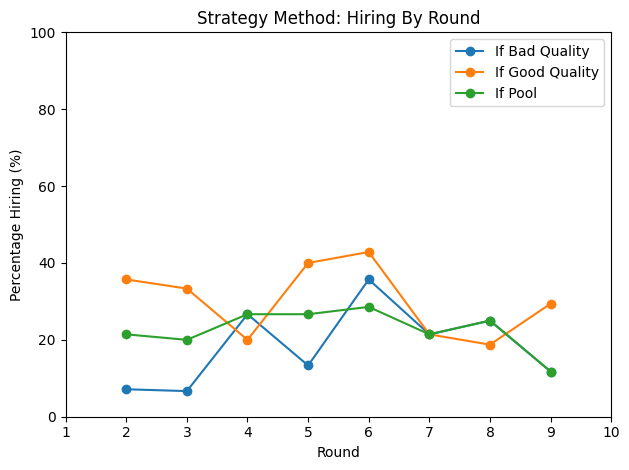

In [40]:
# Here it's optimal not to hire
for fig in range(2):
    #  SEPARATE BAD
    avgs_sep = []
    for i in range(1, rounds_num+1):
        bonus_choice = data_strategy[data_strategy[f'Round{i}Param']>=7][f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
    # lengths = len(bonus_choice)
    print(avgs_sep)
    plt.plot(range(1, rounds_num+1), avgs_sep, label='If Bad Quality', marker="o")

    #  SEPARATE GOOD
    avgs_sep = []
    for i in range(1, rounds_num+1):
        bonus_choice = data_strategy[data_strategy[f'Round{i}Param']>=7][f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
        avg_separating = bonus_choice.mean()*100
        avgs_sep.append(avg_separating)
    # lengths = len(bonus_choice)
    print(avgs_sep)
    plt.plot(range(1, rounds_num+1), avgs_sep, label='If Good Quality', marker="o")

    if fig>0:
        #  POOL
        avgs_pool = []
        for i in range(1, rounds_num+1):
            bonus_choice = data_strategy[data_strategy[f'Round{i}Param']>=7][f'strategy_method.{i}.player.bonusChoicePool'].replace(3, 0)
            avg_pooling = bonus_choice.mean()*100
            avgs_pool.append(avg_pooling)
        #     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
        # lengths = len(bonus_choice)
        print(avgs_pool)
        plt.plot(range(1, rounds_num+1), avgs_pool, label='If Pool', marker="o")

    plt.xlabel("Round")
    plt.ylabel("Percentage Hiring (%)")
    plt.xlim(1,  rounds_num)
    plt.xticks(np.arange(1, rounds_num+1), range(1, rounds_num+1))  # Set text labels.
    plt.ylim(0, 100)
    plt.legend()
    # plt.title(f'Strategy Method: Hiring By Round N={lengths}')
    plt.title(f'Strategy Method: Hiring By Round')
    plt.tight_layout()
    # if fig == 0:
    #     plt.savefig(outputpath + 'strategy_bonus_choice_by_round.png',dpi=1000)
    plt.show()

#### Let's condition on what they do in part 1

##### First, condition on what they'll actually will end up doing

In [ ]:
# for i in range(1,6):
#     myList = []
#     for ind in strategy.index:
#         myList.append(int(strategy[f'strategy_method.{i}.player.environment_choice'][ind]))
#     strategy[f'EnvChoice_R{i}'] = myList

[45.45454545454545, 22.22222222222222, 9.090909090909092, 15.384615384615385, 20.0, 23.076923076923077, 21.428571428571427, 25.0, 26.666666666666668, 42.857142857142854]
[10.526315789473683, 8.333333333333332, 26.31578947368421, 23.52941176470588, 20.0, 11.76470588235294, 12.5, 7.142857142857142, 13.333333333333334, 13.043478260869565]
[84.21052631578947, 75.0, 73.68421052631578, 70.58823529411765, 80.0, 76.47058823529412, 56.25, 71.42857142857143, 46.666666666666664, 78.26086956521739]


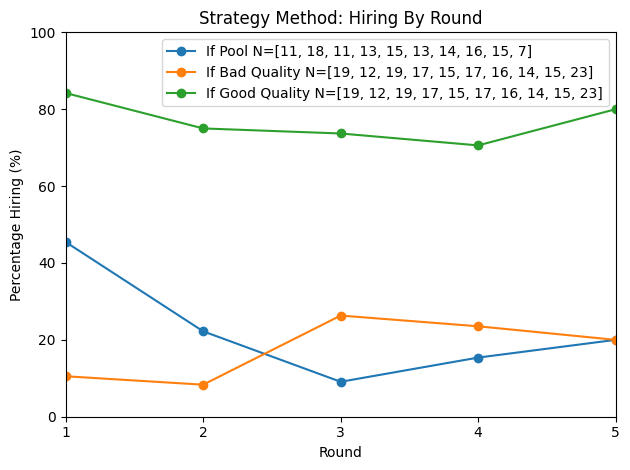

In [42]:
#  POOL
lengths = []
avgs_pool = []
for i in range(1,rounds_num+1):
    strategy_pool = data_strategy[data_strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_pool[f'strategy_method.{i}.player.bonusChoicePool'].replace(3, 0)
    avg_pooling = bonus_choice.mean()*100
    avgs_pool.append(avg_pooling)
#     print(base_pool[f'informational_cost.{i}.player.bonusChoice'], bonus_choice)
    lengths.append(len(bonus_choice))
print(avgs_pool)
plt.plot(range(1,rounds_num+1), avgs_pool, label=f'If Pool N={lengths}', marker="o")

#  SEPARATE BAD
lengths = []
avgs_sep = []
for i in range(1,rounds_num+1):
    strategy_sep = data_strategy[data_strategy[f'EnvChoice_R{i}']==0]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,rounds_num+1), avgs_sep, label=f'If Bad Quality N={lengths}', marker="o")

#  SEPARATE GOOD
lengths = []
avgs_sep = []
for i in range(1,rounds_num+1):
    strategy_sep = data_strategy[data_strategy[f'EnvChoice_R{i}']==0]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,rounds_num+1), avgs_sep, label=f'If Good Quality N={lengths}', marker="o")

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title('Strategy Method: Hiring By Round')
plt.tight_layout()
plt.savefig(outputpath + 'strategy_bonus_choice_by_round_matters.png',dpi=1000)
plt.show()

##### Now, check what those who pooled said they would have done if separating

[36.36363636363637, 11.11111111111111, 0.0, 15.384615384615385, 20.0, 30.76923076923077, 14.285714285714285, 25.0, 20.0, 57.14285714285714]
[72.72727272727273, 33.33333333333333, 27.27272727272727, 23.076923076923077, 33.33333333333333, 30.76923076923077, 21.428571428571427, 31.25, 53.333333333333336, 57.14285714285714]


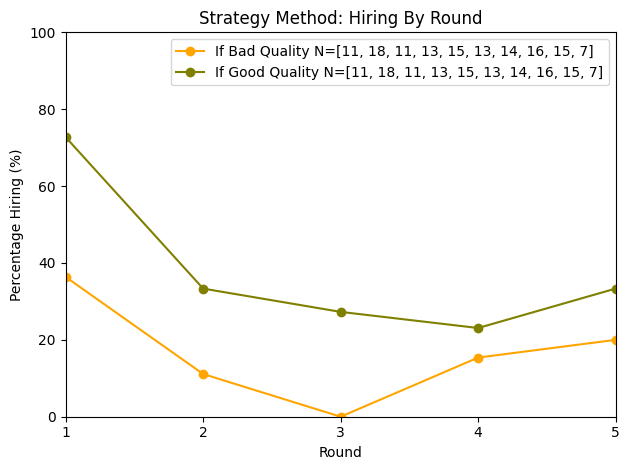

In [43]:
#  SEPARATE BAD
lengths = []
avgs_sep = []
for i in range(1,rounds_num+1):
    strategy_sep = data_strategy[data_strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepBad'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,rounds_num+1), avgs_sep, label=f'If Bad Quality N={lengths}', marker="o", color='orange')

#  SEPARATE GOOD
lengths = []
avgs_sep = []
for i in range(1,rounds_num+1):
    strategy_sep = data_strategy[data_strategy[f'EnvChoice_R{i}']==1]
    bonus_choice = strategy_sep[f'strategy_method.{i}.player.bonusChoiceSepGood'].replace(3, 0)
    avg_separating = bonus_choice.mean()*100
    avgs_sep.append(avg_separating)
    lengths.append(len(bonus_choice))
print(avgs_sep)
plt.plot(range(1,rounds_num+1), avgs_sep, label=f'If Good Quality N={lengths}', marker="o", color='olive')

plt.xlabel("Round")
plt.ylabel("Percentage Hiring (%)")
plt.xlim(1, 5)
plt.xticks(np.arange(1,6), range(1,6))  # Set text labels.
plt.ylim(0, 100)
plt.axvline(x=5.5, linewidth=2, color = 'k')
plt.legend()
plt.title('Strategy Method: Hiring By Round')
plt.tight_layout()
plt.savefig(outputpath + 'strategy_bonus_choice_by_round_NOTmatters.png',dpi=1000)
plt.show()

### Let's see if some people always pool or always separate

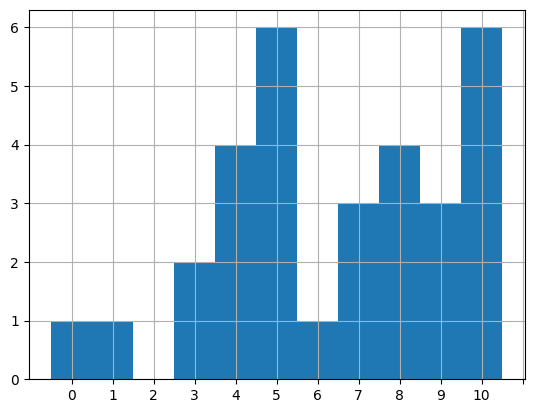

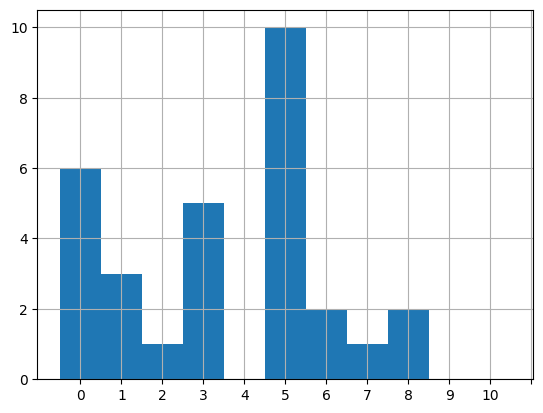

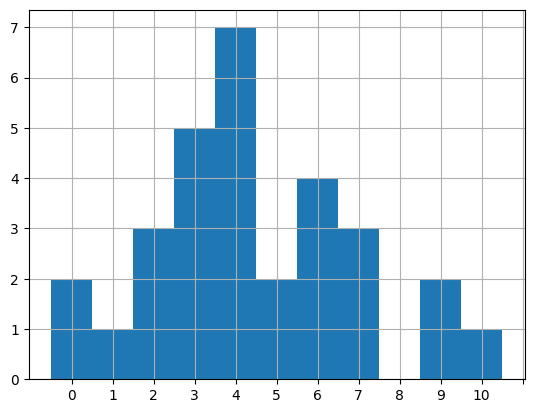

In [40]:
data_base['total_pool'] = data_base['EnvChoice_R1']+data_base['EnvChoice_R2']+data_base['EnvChoice_R3']+data_base['EnvChoice_R4']+data_base['EnvChoice_R5']+data_base['EnvChoice_R6']+\
                            data_base['EnvChoice_R7']+data_base['EnvChoice_R8']+data_base['EnvChoice_R9']+data_base['EnvChoice_R10']
data_base['total_pool'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.xticks(np.arange(0,rounds_num+2), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.show()
data_salient['total_pool'] = data_salient['EnvChoice_R1']+data_salient['EnvChoice_R2']+data_salient['EnvChoice_R3']+data_salient['EnvChoice_R4']+data_salient['EnvChoice_R5']+data_salient['EnvChoice_R6']+\
                            data_salient['EnvChoice_R7']+data_salient['EnvChoice_R8']+data_salient['EnvChoice_R9']+data_salient['EnvChoice_R10']
data_salient['total_pool'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.xticks(np.arange(0,rounds_num+2), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.show()
data_strategy['total_pool'] = data_strategy['EnvChoice_R1']+data_strategy['EnvChoice_R2']+data_strategy['EnvChoice_R3']+data_strategy['EnvChoice_R4']+data_strategy['EnvChoice_R5']+data_strategy['EnvChoice_R6']+\
                            data_strategy['EnvChoice_R7']+data_strategy['EnvChoice_R8']+data_strategy['EnvChoice_R9']+data_strategy['EnvChoice_R10']
data_strategy['total_pool'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.xticks(np.arange(0,rounds_num+2), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.show()

5 params are Separating in baseline in salient; 6 params are Separating in Strategy --- update this later!!!
Base: [68.0, 40.0, 38.46153846153847, 27.27272727272727, 9.090909090909092, 41.66666666666667, 40.0, 50.0, 30.0, 53.84615384615385] Salient: [33.33333333333333, 9.090909090909092, 15.384615384615385, 41.66666666666667, 15.384615384615385, 23.076923076923077, 20.0, 14.285714285714285, 7.142857142857142, 26.666666666666668] Strategy: [34.48275862068966, 31.25, 14.285714285714285, 33.33333333333333, 40.0, 25.0, 20.0, 23.076923076923077, 41.66666666666667, 20.689655172413794]


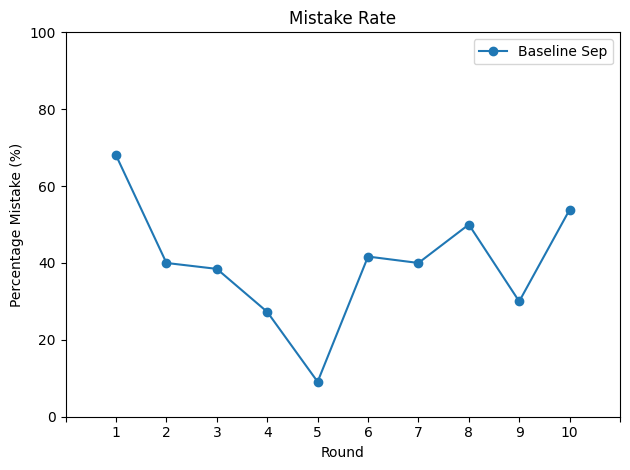

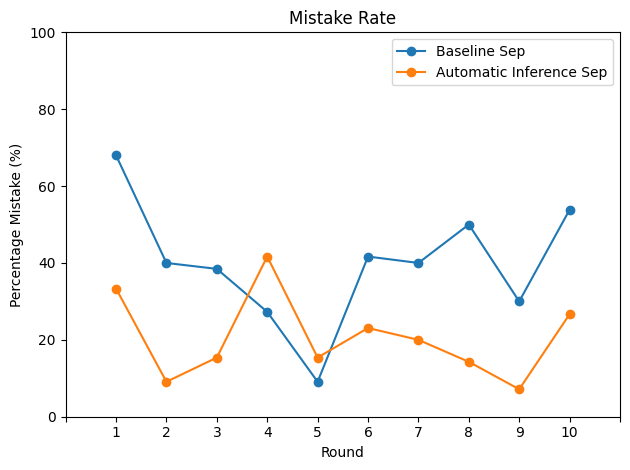

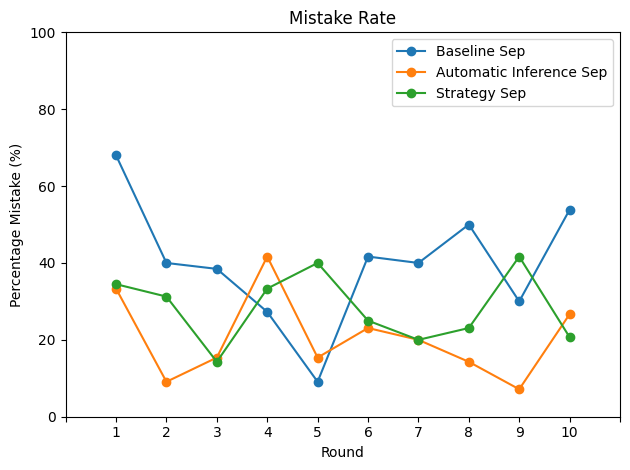

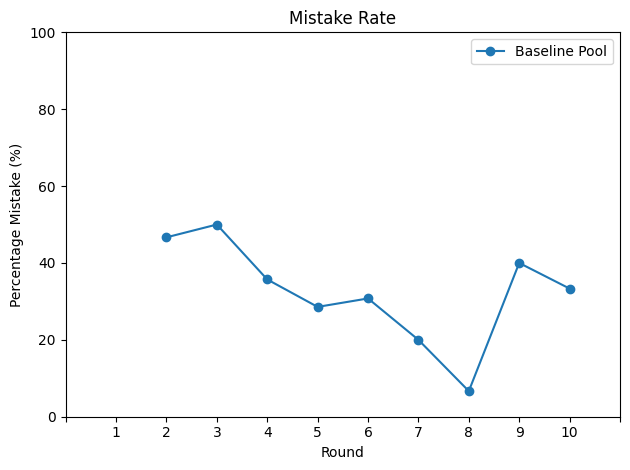

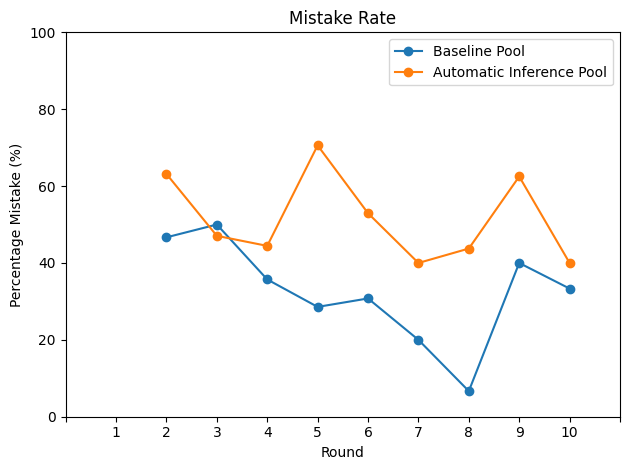

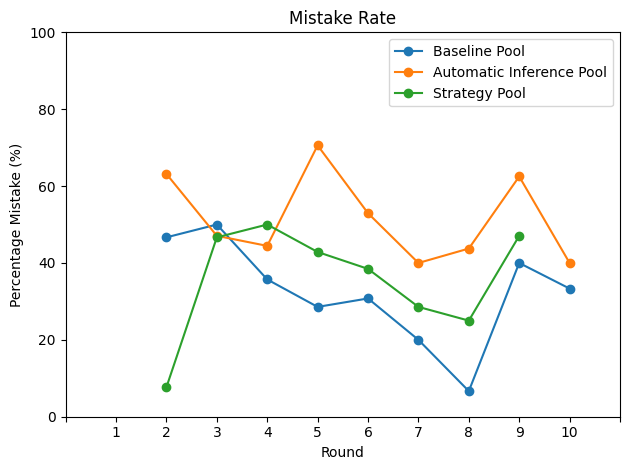

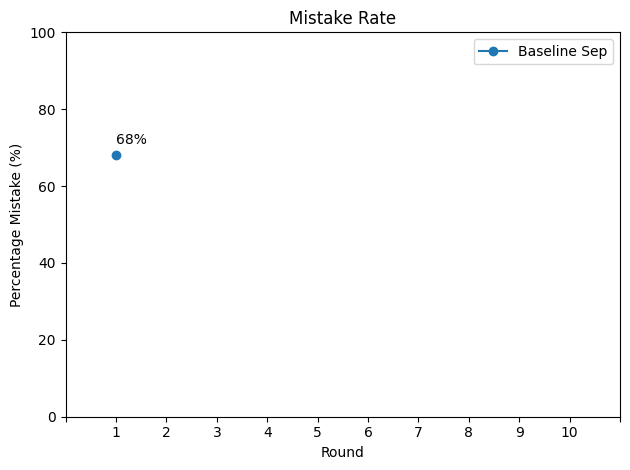

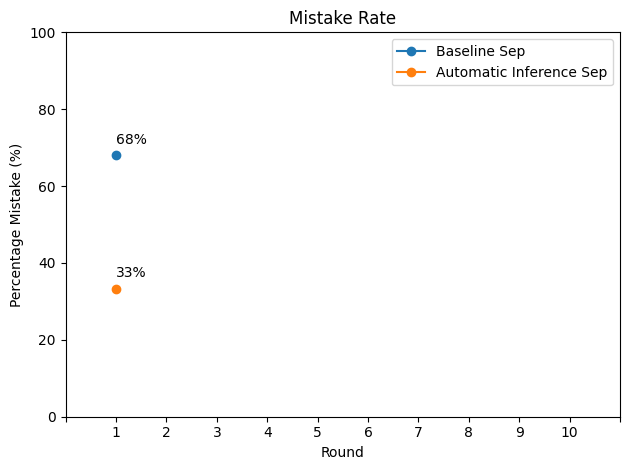

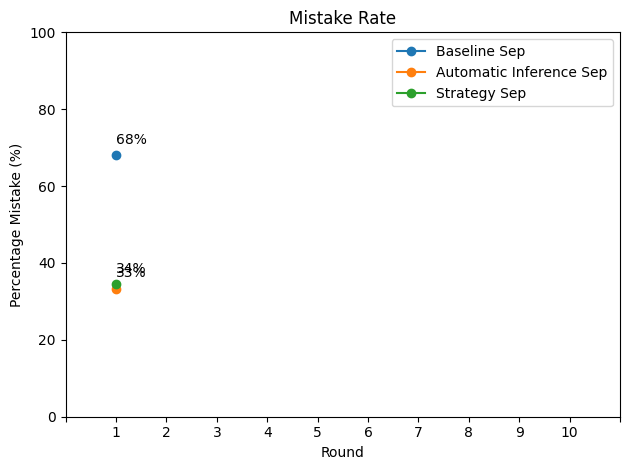

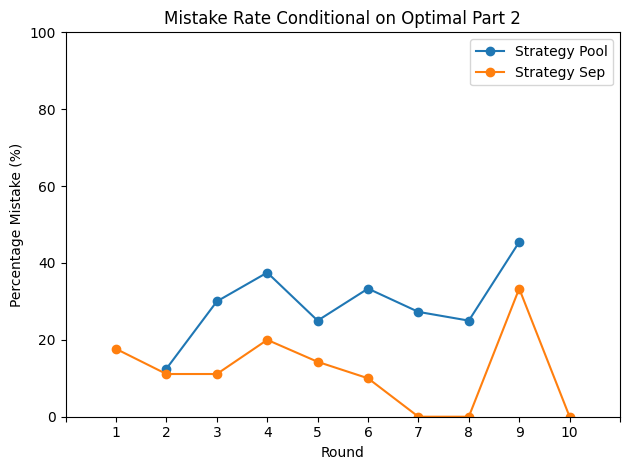

In [41]:
# Drop everyone who always chooses the same task and repeat graphs for part 1
# data_base = data_base[(data_base['total_pool']>0) & (data_base['total_pool']<10)]
# data_salient = data_salient[(data_salient['total_pool']>0) & (data_salient['total_pool']<10)]
# data_strategy = data_strategy[(data_strategy['total_pool']>0) & (data_strategy['total_pool']<10)]
data_base = data_base[(data_base['total_pool']<10)]
data_salient = data_salient[(data_salient['total_pool']<10)]
data_strategy = data_strategy[(data_strategy['total_pool']<10)]

mist_base_sep = []
mist_base_pool = []
mist_salient_sep = []
mist_salient_pool = []
mist_strategy_sep = []
mist_strategy_pool = []
mist_strategy_sep2 = []
mist_strategy_pool2 = []
rounds_num = 10
lengths_base_sep=[]
lengths_base_pool=[]
lengths_salient_sep=[]
lengths_salient_pool=[]
lengths_strategy_sep=[]
lengths_strategy_pool=[]
lengths_strategy_sep2=[]
lengths_strategy_pool2=[]
print('5 params are Separating in baseline in salient; 6 params are Separating in Strategy --- update this later!!!')

for i in range(1,rounds_num+1):
#   BASELINE
    # base_sep = data_base[data_base[f'Round{i}Param']<6] # baseline when separating is optimal
    # base_pool = data_base[data_base[f'Round{i}Param']>=6] # baseline when pooling is optimal
    # base_risk = base[base[f'risk_taker_R{i}'] == 1] # this picks people who picked risky option in that round's lottery
    # base_risk = base_risk[base_risk[f'Round{i}Param'] != 5] # this kicks out those for whom pooling was optimal
    base_sep = data_base[data_base[f'Round{i}Param']<6] # baseline when separating is optimal
    base_pool = data_base[data_base[f'Round{i}Param']>=6] # baseline when pooling is optimal
    salient_sep = data_salient[data_salient[f'Round{i}Param']<6] # salient when separating is optimal
    salient_pool = data_salient[data_salient[f'Round{i}Param']>=6] # salient when pooling is optimal
    strategy_sep = data_strategy[data_strategy[f'Round{i}Param']<7] # strategy when separating is optimal
    strategy_pool = data_strategy[data_strategy[f'Round{i}Param']>=7] # strategy when pooling is optimal
    strategy_sep2 = data_strategy[(data_strategy[f'Round{i}Param']<7) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepGood']==1) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepBad']==3)] # strategy when separating is optimal
    strategy_pool2 = data_strategy[(data_strategy[f'Round{i}Param']>=7) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepGood']==3) & (data_strategy[f'strategy_method.{i}.player.bonusChoiceSepBad']==3) & (data_strategy[f'strategy_method.{i}.player.bonusChoicePool']==3)] # strategy when pooling is optimal
    mist_environment = base_sep[f'informational_cost.{i}.player.environment_choice'].mean()*100
    mist_base_sep.append(mist_environment)
    lengths_base_sep.append(len(base_sep[base_sep[f'Round{i}Param']<6]))
    mist_environment = salient_sep[f'informational_cost.{i}.player.environment_choice'].mean()*100
    mist_salient_sep.append(mist_environment)
    lengths_salient_sep.append(len(salient_sep[salient_sep[f'Round{i}Param']<6]))
    mist_environment = strategy_sep[f'strategy_method.{i}.player.environment_choice'].mean()*100
    mist_strategy_sep.append(mist_environment)
    lengths_strategy_sep.append(len(strategy_sep[strategy_sep[f'Round{i}Param']<7]))
    mist_environment = strategy_sep2[f'strategy_method.{i}.player.environment_choice'].mean()*100
    mist_strategy_sep2.append(mist_environment)
    lengths_strategy_sep2.append(len(strategy_sep2[strategy_sep2[f'Round{i}Param']<7]))
    if i>1:
        mist_environment = (1-base_pool[f'informational_cost.{i}.player.environment_choice'].mean())*100
        mist_base_pool.append(mist_environment)
        lengths_base_pool.append(len(base_pool[base_pool[f'Round{i}Param']>=6]))
        mist_environment = (1-salient_pool[f'informational_cost.{i}.player.environment_choice'].mean())*100
        mist_salient_pool.append(mist_environment)
        lengths_salient_pool.append(len(salient_pool[salient_pool[f'Round{i}Param']>=6]))
        if i<rounds_num:
            mist_environment = (1-strategy_pool[f'strategy_method.{i}.player.environment_choice'].mean())*100
            mist_strategy_pool.append(mist_environment)
            lengths_strategy_pool.append(len(strategy_pool[strategy_pool[f'Round{i}Param']>=7]))
            mist_environment = (1-strategy_pool2[f'strategy_method.{i}.player.environment_choice'].mean())*100
            mist_strategy_pool2.append(mist_environment)
            lengths_strategy_pool2.append(len(strategy_pool2[strategy_pool2[f'Round{i}Param']>=7]))

# print(mist_strategy_pool2)
# print(mist_strategy_sep2)
# print(lengths_strategy_pool2)
# print(lengths_strategy_sep2)

# print('Chose risky in first round:', strategy[strategy['risk_taker_R1'] == 1]['risk_taker_R1'].count())
print('Base:', mist_base_sep, 'Salient:', mist_salient_sep, 'Strategy:', mist_strategy_sep)

for fig in range(6): 
    # plt.plot(range(1,rounds_num+1), mist_base_sep, label=f'Baseline Sep N={lengths_base_sep}', marker="o")
    if fig<=2:
        plt.plot(range(1,rounds_num+1), mist_base_sep, label=f'Baseline Sep', marker="o")    # plt.plot(range(1,2), avgs_base, label=f'Baseline N={lengths_base[0]}', marker="o")
    if fig>0 and fig<=2:
        # plt.plot(range(1,rounds_num+1), mist_salient_sep, label=f'Salient Sep N={lengths_salient_sep}', marker="o")
        plt.plot(range(1,rounds_num+1), mist_salient_sep,  label=f'Automatic Inference Sep', marker="o")

    if fig>1 and fig<=2:
        # plt.plot(range(1,rounds_num+1), mist_salient_sep, label=f'Salient Sep N={lengths_salient_sep}', marker="o")
        plt.plot(range(1,rounds_num+1), mist_strategy_sep,  label=f'Strategy Sep', marker="o")

    # # plt.plot(range(1,2), avgs_salient, label=f'Salient N={lengths_salient[0]}', marker="o")
    if fig>2:
        # plt.plot(range(2,rounds_num+1), mist_base_pool, label=f'Baseline Pool N={lengths_base_pool}', marker="o")
        plt.plot(range(2,rounds_num+1), mist_base_pool, label=f'Baseline Pool', marker="o")

    if fig>3:
        # plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Salient Pool N={lengths_salient_pool}', marker="o")
        plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Automatic Inference Pool', marker="o")

    if fig>4:
        # plt.plot(range(2,rounds_num+1), mist_salient_pool, label=f'Salient Pool N={lengths_salient_pool}', marker="o")
        plt.plot(range(2,rounds_num), mist_strategy_pool, label=f'Strategy Pool', marker="o")

    # # plt.plot(range(1,rounds_num+1), avgs_strategy, label=f'Strategy Method N={lengths_strategy}', marker="o")
    # plt.plot(range(1,2), avgs_strategy, label=f'Strategy Method N={lengths_strategy[0]}', marker="o")

    plt.xlabel("Round")
    plt.ylabel("Percentage Mistake (%)")
    plt.xlim(0, rounds_num+1)
    plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
    plt.ylim(0, 100)
    # plt.axvline(x=5.5, linewidth=2, color = 'k')
    # plt.axhline(y=avgs_base_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
    # plt.text(2.5,avgs_base_avg+3,str(round(avgs_base_avg,1))+'%')
    # plt.text(0.85,avgs_base[0]+3,str(round(avgs_base[0]))+'%')
    # plt.text(0.85,avgs_salient[0]+3,str(round(avgs_salient[0]))+'%')
    # plt.text(0.85,avgs_strategy[0]-4,str(round(avgs_strategy[0]))+'%')

    # plt.axhline(y=avgs_sal_avg, xmin=0,xmax=0.5, linewidth=1, color = 'k')
    # plt.text(2.5,avgs_sal_avg-4,str(round(avgs_sal_avg,1))+'%')

    plt.legend()
    plt.title(f'Mistake Rate')
    plt.tight_layout()
    # plt.savefig(outputpath + 'environment_by_round_baseline_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_baseline.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_salient_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_salient.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_strategy_R1.png',dpi=1000)
    # plt.savefig(outputpath + 'environment_by_round_strategy.png',dpi=1000)
    # if fig==0:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_sep.png',dpi=1000)
    # if fig==1:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_salient_sep.png',dpi=1000)
    # if fig==2:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_salient_strategy_sep.png',dpi=1000)
    # if fig==3:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_pool.png',dpi=1000)
    # if fig==4:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_salient_pool.png',dpi=1000)
    # if fig==5:
    #     plt.savefig(outputpath + 'environment_by_round_baseline_salient_strategy_pool.png',dpi=1000)
    plt.show()

plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_round_1_baseline_sep.png',dpi=1000)
plt.show()

plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.plot([1], mist_salient_sep[0], label=f'Automatic Inference Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.text(1,mist_salient_sep[0]+3,str(round(mist_salient_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_round_1_salient_sep.png',dpi=1000)
plt.show()

plt.plot([1], mist_base_sep[0], label=f'Baseline Sep', marker="o")
plt.plot([1], mist_salient_sep[0], label=f'Automatic Inference Sep', marker="o")
plt.plot([1], mist_strategy_sep[0], label=f'Strategy Sep', marker="o")
plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.text(1,mist_base_sep[0]+3,str(round(mist_base_sep[0]))+'%')
plt.text(1,mist_salient_sep[0]+3,str(round(mist_salient_sep[0]))+'%')
plt.text(1,mist_strategy_sep[0]+3,str(round(mist_strategy_sep[0]))+'%')
plt.legend()
plt.title(f'Mistake Rate')
plt.tight_layout()
# plt.savefig(outputpath + 'environment_round_1_strategy_sep.png',dpi=1000)
plt.show()

plt.xlabel("Round")
plt.ylabel("Percentage Mistake (%)")
plt.xlim(0, rounds_num+1)
plt.xticks(np.arange(0,rounds_num+2), ['', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', ''])  # Set text labels.
plt.ylim(0, 100)
plt.title(f'Mistake Rate Conditional on Optimal Part 2')
plt.tight_layout()
plt.plot(range(2,rounds_num), mist_strategy_pool2, label=f'Strategy Pool', marker="o")
plt.plot(range(1,rounds_num+1), mist_strategy_sep2, label=f'Strategy Sep', marker="o")
plt.legend()
# plt.savefig(outputpath + 'environment_by_round_strategy_opt_part2.png',dpi=1000)
plt.show()

### Baseline: Check if there is a group of people who always pool, or people going in and out

In [ ]:
base['cum_mistakes_R1'] = np.nan
base['cum_mistakes_R2'] = np.nan
base['cum_mistakes_R3'] = np.nan
base['cum_mistakes_R4'] = np.nan
base['cum_mistakes_R5'] = np.nan
for ind in base.index:
    if base['risk_taker_R1'][ind] == 1 and base['Round1Param'][ind] != 5:
        base['cum_mistakes_R1'][ind] = base['EnvChoice_R1'][ind]
    else:
        base['cum_mistakes_R1'][ind] = 0
    if base['risk_taker_R2'][ind] == 1 and base['Round2Param'][ind] != 5:
        base['cum_mistakes_R2'][ind] = base['cum_mistakes_R1'][ind] + base['EnvChoice_R2'][ind]
    else:
        base['cum_mistakes_R2'][ind] = base['cum_mistakes_R1'][ind]
    if base['risk_taker_R3'][ind] == 1 and base['Round3Param'][ind] != 5:
        base['cum_mistakes_R3'][ind] = base['cum_mistakes_R2'][ind] + base['EnvChoice_R3'][ind]
    else:
        base['cum_mistakes_R3'][ind] = base['cum_mistakes_R2'][ind]
    if base['risk_taker_R4'][ind] == 1 and base['Round4Param'][ind] != 5:
        base['cum_mistakes_R4'][ind] = base['cum_mistakes_R3'][ind] + base['EnvChoice_R4'][ind]
    else:
        base['cum_mistakes_R4'][ind] = base['cum_mistakes_R3'][ind]
    if base['risk_taker_R5'][ind] == 1 and base['Round5Param'][ind] != 5:
        base['cum_mistakes_R5'][ind] = base['cum_mistakes_R4'][ind] + base['EnvChoice_R5'][ind]
    else:
        base['cum_mistakes_R5'][ind] = base['cum_mistakes_R4'][ind]        

print(base[['cum_mistakes_R1', 'cum_mistakes_R2','cum_mistakes_R3', 'cum_mistakes_R4','cum_mistakes_R5']])

     cum_mistakes_R1  cum_mistakes_R2  cum_mistakes_R3  cum_mistakes_R4  \
179              0.0              0.0              1.0              1.0   
181              1.0              2.0              2.0              2.0   
182              1.0              1.0              2.0              3.0   
232              1.0              1.0              1.0              1.0   
237              1.0              2.0              3.0              3.0   
239              1.0              2.0              2.0              2.0   
243              0.0              0.0              0.0              0.0   
247              1.0              2.0              2.0              2.0   
248              0.0              0.0              0.0              0.0   
252              1.0              2.0              2.0              3.0   
253              1.0              2.0              3.0              4.0   
255              0.0              0.0              1.0              2.0   
257              1.0     

In [ ]:
for i in range(1,6):
    print(base[base['cum_mistakes_R5']==4][f'informational_cost.{i}.player.bonusChoice'])

182    1.0
252    1.0
253    1.0
279    1.0
305    3.0
Name: informational_cost.1.player.bonusChoice, dtype: float64
182    3.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.2.player.bonusChoice, dtype: float64
182    1.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.3.player.bonusChoice, dtype: float64
182    1.0
252    3.0
253    1.0
279    3.0
305    1.0
Name: informational_cost.4.player.bonusChoice, dtype: float64
182    3.0
252    3.0
253    1.0
279    3.0
305    3.0
Name: informational_cost.5.player.bonusChoice, dtype: float64


In [ ]:
base_pool1 = base_all[base_all['EnvChoice1']==1]
base_sep_good1 = base_all[(base_all['EnvChoice1']==0) & (base_all['RoundCounts1CompType']==1)]
base_sep_bad1 = base_all[(base_all['EnvChoice1']==0) & (base_all['RoundCounts1CompType']==0)]
base_pool2 = base_all[base_all['EnvChoice2']==1]
base_sep_good2 = base_all[(base_all['EnvChoice2']==0) & (base_all['RoundCounts2CompType']==1)]
base_sep_bad2 = base_all[(base_all['EnvChoice2']==0) & (base_all['RoundCounts2CompType']==0)]
base_sep_bad2
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_pool1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (pool, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who pool in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_pool2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (pool, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_good1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, good, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_good2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, good, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_bad1['informational_cost.5.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, bad, first) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in second part 2
fig, ax = plt.subplots()
y = [int(i) for i in base_sep_bad2['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Base - Part 2 (separate, bad, second) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

NameError: name 'base_all' is not defined

### Salient part 2

In [ ]:
#%%
salient_all = data[data['participant.treatment']=='salient']
for ind in salient_all.index:
    salient_all['participant.chosen_decisions'][ind] = int(salient_all['participant.chosen_decisions'][ind][0])
salient_all = salient_all[(salient_all['participant.chosen_decisions']<6)]
#%%
myList = []
for ind in salient_all.index:
    myList.append(int(salient_all['participant.compType'][ind][int(salient_all['participant.chosen_decisions'][ind])-1]))
    # print(myList,  data['participant.compType'])
salient_all['RoundCounts1CompType'] = myList
#%%
myList = []
for ind in salient_all.index:
    r1 = int(salient_all['participant.chosen_decisions'][ind])
    myList.append(int(salient_all[f'informational_cost.{r1}.player.environment_choice'][ind]))
    # print(myList,  data['participant.compType'])
salient_all['EnvChoice1'] = myList
#%%
salient_pool = salient_all[salient_all['EnvChoice1']==1]
salient_sep_good = salient_all[(salient_all['EnvChoice1']==0) & (salient_all['RoundCounts1CompType']==1)]
salient_sep_bad = salient_all[(salient_all['EnvChoice1']==0) & (salient_all['RoundCounts1CompType']==0)]
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_pool['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (pool) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Good in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_sep_good['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (separate, good) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate and Bad in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in salient_sep_bad['informational_cost.10.player.bonusChoice']]
xLabels = ['','Computer','', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Salient - Part 2 (separate, bad) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

### Deterministic part 2

In [ ]:
#%%
det_all = data[(data['participant.treatment'] == 'deterministic')]
for ind in det_all.index:
    det_all['participant.chosen_decisions'][ind] = int(det_all['participant.chosen_decisions'][ind][0])
det_all = det_all[(det_all['participant.chosen_decisions']<6)]

myList = []
for ind in det_all.index:
    r1 = int(det_all['participant.chosen_decisions'][ind])
    myList.append(int(det_all[f'informational_cost.{r1}.player.environment_choice'][ind]))
    # print(myList,  data['participant.compType'])
det_all['EnvChoice1'] = myList
det_pool = det_all[det_all['EnvChoice1'] == 1]
det_sep = det_all[det_all['EnvChoice1'] == 0]
#%%
# Those who pool in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in det_pool['informational_cost.10.player.bonusChoice']]
xLabels = ['', 'Good', 'Bad', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Deterministic - Part 2 (pool) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()

# Those who separate in first part 2
fig, ax = plt.subplots()
y = [int(i) for i in det_sep['informational_cost.10.player.bonusChoice']]
xLabels = ['', 'Good', 'Bad', 'Outside Option', '']
x = np.arange(max(y)+2)
ax.hist(y,x-0.5, width=1)
plt.ylabel('Frequency')
for i in range(max(y)+2):
    plt.text(i,y.count(i)-1,str(y.count(i))+ ' (' + str(round(y.count(i)*100/len(y))) +'%)', color='white')
plt.xticks(x, xLabels)
plt.title(f'Deterministic - Part 2 (separate) Choice N={len(y)}')
plt.tight_layout()
# plt.savefig(outputpath + baseline['inference.1.player.bonusChoice'].name[19:] +'.png',dpi=1000)
plt.show()